# Import Repo of Sepsis Simulator

In [1]:
!git clone https://github.com/clinicalml/gumbel-max-scm.git

Cloning into 'gumbel-max-scm'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 113 (delta 0), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (113/113), 1.48 MiB | 8.64 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [2]:
#Enable importing code from parent directory
import os, sys
simulator_path = os.path.abspath('./gumbel-max-scm')
sys.path.insert(1, simulator_path)

In [3]:
!pip install pymdptoolbox

  Preparing metadata (setup.py) ... done
  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-py3-none-any.whl size=25657 sha256=753a659db1079dc2e736832fea73a56536286c70980f9939ca99f6e689d19555
  Stored in directory: /root/.cache/pip/wheels/2b/e7/c7/d7abf9e309f3573a934fed2750c70bd75d9e9d901f7f16e183
Successfully built pymdptoolbox


**IMPORTANT NOTE:** At this stage, to reproduce our experiments, one must modify line 38 of `gumbel-max-scm/sepsisSimDiabetes/DataGenerator.py` so that it reads:

```
mdp = MDP(init_state_idx=%state%,
          policy_array=policy, policy_idx_type=policy_idx_type,
          p_diabetes=p_diabetes)

```

We have essentially set the initial state to a fixed value so that we may estimate the Q-function from that state. Additionally, line 58 of the same file must be modified to:

```
mdp.state = mdp.get_new_state(state_idx = %state%)
```

In [4]:
import numpy as np
import cf.counterfactual as cf
import cf.utils as utils
import pandas as pd
import pickle
import itertools as it
from tqdm import tqdm_notebook as tqdm
from scipy.linalg import block_diag

# Sepsis Simulator code
from sepsisSimDiabetes.State import State
from sepsisSimDiabetes.Action import Action
from sepsisSimDiabetes.DataGenerator import DataGenerator
import sepsisSimDiabetes.MDP as simulator

import mdptoolboxSrc.mdp as mdptools

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set up Variables and Functions

Code taken from [Oberst and Sontag](https://github.com/clinicalml/gumbel-max-scm/blob/master/plots-main-paper.ipynb).

Set up important variables

In [5]:
#Typically the seed is set to 1 but we set to 20 to get a new random data set
SEED = 20
np.random.seed(SEED)
NSIMSAMPS = 100000  # Samples to draw from the simulator
NSTEPS = 20  # Max length of each trajectory
NCFSAMPS = 5  # Counterfactual Samples per observed sample
DISCOUNT_Pol = 0.99 # Used for computing optimal policies
DISCOUNT = 1 # Used for computing actual reward
PHYS_EPSILON = 0.05 # Used for sampling using physician pol as eps greedy

# Option 1: Use bootstrapping w/replacement on the original NSIMSAMPS to estimate errors
USE_BOOSTRAP=True
N_BOOTSTRAP = 100

# Option 2: Use repeated sampling (i.e., NSIMSAMPS fresh simulations each time) to get error bars;
# This is done in the appendix of the paper, but not in the main paper
N_REPEAT_SAMPLING = 1

# These are properties of the simulator, do not change
n_actions = Action.NUM_ACTIONS_TOTAL
n_components = 2

# These are added as absorbing states
n_states_abs = State.NUM_OBS_STATES + 2
discStateIdx = n_states_abs - 1
deadStateIdx = n_states_abs - 2

# Number of runs for calculating MSE
RUNS = 20
# Number of episodes over which we average an OPE estimate
N = 1000

Set up base for behaviour and evaluation policies

In [6]:
import zipfile
with zipfile.ZipFile("gumbel-max-scm/data/diab_txr_mats-replication.zip", 'r') as zip_ref:
    zip_ref.extractall("gumbel-max-scm/data")

In [7]:
# Get the transition and reward matrix from file
with open("gumbel-max-scm/data/diab_txr_mats-replication.pkl", "rb") as f:
    mdict = pickle.load(f)

tx_mat = mdict["tx_mat"]
r_mat = mdict["r_mat"]

In [8]:
from scipy.linalg import block_diag

tx_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))
r_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))

# Easily accessible variables
A = n_actions
S = State.NUM_FULL_STATES

for a in range(n_actions):
    tx_mat_full[a, ...] = block_diag(tx_mat[0, a, ...], tx_mat[1, a,...])
    r_mat_full[a, ...] = block_diag(r_mat[0, a, ...], r_mat[1, a, ...])

In [9]:
fullMDP = cf.MatrixMDP(tx_mat_full, r_mat_full)
fullPol = fullMDP.policyIteration(discount=DISCOUNT_Pol, eval_type=1)

#The behavior policy is the fully random policy
randPol = np.ones(fullPol.shape)/(fullPol.shape[1])

In [10]:
#We want the expected reward of starting in a state and taking an action
R = np.swapaxes(np.mean(r_mat_full, axis=-1), 0, 1)
R.shape

(1440, 8)

In [11]:
#To handle -1 states and -1 actions
def pad_policy(policy, val=1):
  #Add a column of zeroes to the end
  policy = np.concatenate((policy, np.full((policy.shape[0], 1), val)), axis=1)
  #Add a row of zeroes at the end
  policy = np.concatenate((policy, np.full((1, policy.shape[1]), val)), axis=0)
  return policy

# Load repo

In [12]:
!git clone https://github.com/ai4ai-lab/Factored-Action-Spaces-for-OPE.git

Cloning into 'Factored-Action-Spaces-for-OPE'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 93 (delta 20), reused 71 (delta 7), pack-reused 0
Receiving objects: 100% (93/93), 2.94 MiB | 10.32 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [13]:
#Enable importing code from parent directory
import os, sys
main_folder = os.path.abspath('./Factored-Action-Spaces-for-OPE')
sys.path.insert(1, main_folder)

# From Patient State 136, With Diabetes

In [ ]:
#The patient has diabetes
PROB_DIAB = 1.0

### Varying Episodes $\epsilon_{e} = 0.4$ (Policy Divergence $4.8^{20}$)

Set up evaluation policy, generate data and convert into factored format

In [ ]:
EVAL_EPSILON = 0.4

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
# Calculate policy divergence from Voloshin et al.
D = 0
for state in range(randPol.shape[0] - 1):
    for action in range(randPol.shape[1] - 1):
        difference = evalPolSoft[state, action]/randPol[state, action]
        D = max(D, difference)
print(D)
shorter_D = round(D,2)

4.8


In [ ]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=evalPolSoft, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_e = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_e.shape

(100000, 20, 5)

In [ ]:
print(nf_tr_e)

[[[  0. 136.   6.   0. 141.]
  [  1. 141.   0.   0. 144.]
  [  2. 144.   2.   0. 385.]
  ...
  [ 17. 469.   6.   0. 381.]
  [ 18. 381.   0.   0. 616.]
  [ 19. 616.   6.   0. 381.]]

 [[  0. 136.   2.   0. 129.]
  [  1. 129.   2.   0. 217.]
  [  2. 217.   2.  -1. 209.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   3.   0. 467.]
  [  1. 467.   6.   0. 477.]
  [  2. 477.   6.   0. 397.]
  ...
  [ 17. 389.   7.   0. 471.]
  [ 18. 471.   6.   0. 389.]
  [ 19. 389.   0.   0. 392.]]

 ...

 [[  0. 136.   5.  -1. 230.]
  [  1. 230.  -1.   0.  -1.]
  [  2.  -1.  -1.   0.  -1.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   6.   0. 133.]
  [  1. 133.   2.   0. 129.]
  [  2. 129.   7.  -1. 215.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   2.   0. 137.]
  [  1. 137.   6.   0. 133.]
  [  2. 133.   5.  -1. 214

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


Run the data generator to generate behaviour policy data

In [ ]:
randPol = np.ones(fullPol.shape)/(fullPol.shape[1])

dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=randPol, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

Convert data into array format

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_b = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_b.shape

(100000, 20, 5)

In [ ]:
def pred_model_sa(model, test_data, *args):
  model.eval()
  mean = torch.zeros((1), dtype=torch.float32).to(device)
  for run in range(test_data.shape[0]):
    episode = test_data[run, :, :]
    #Filter out -1 states and actions
    episode = episode[episode[:, 2] != -1, :]
    states_and_actions = torch.as_tensor(episode[:, 1:3], dtype=torch.float32).to(device)
    # Compute prediction and loss
    factored_pol_reward = model(states_and_actions) #Use predictions from network to calculate OPE estimates
    D = list(factored_pol_reward.size())[-1]//3
    factored_pi_b = factored_pol_reward[:, :D]
    factored_pi_e = factored_pol_reward[:, D:2*D]
    factored_reward = factored_pol_reward[:, 2*D:]

    pointwise_IS_ratios = torch.div(factored_pi_e, factored_pi_b)
    IS_ratios = torch.prod(pointwise_IS_ratios, 0)

    times = torch.as_tensor(np.repeat(np.expand_dims(episode[:, 0], axis=1), D, axis=1)).to(device)
    # Per-trajectory returns (discounted cumulative rewards)
    gamma = torch.full(times.shape, DISCOUNT_Pol).to(device)
    G = torch.mul(factored_reward, torch.pow(gamma, times)).sum()

    mean.to(device)
    mean = torch.add(mean, G.div(test_data.shape[0]))
  return mean.to('cpu')

In [ ]:
def pred_model_rp(model, test_data, pi_b, pi_e, discount_factor):
  model.eval()
  mean = torch.zeros((1), dtype=torch.float32).to(device)
  for run in range(test_data.shape[0]):
    episode = test_data[run, :, :]
    #Filter out -1 states and actions
    episode = episode[episode[:, 2] != -1, :]
    S = episode[:, 1].astype('int32')
    A = episode[:,2].astype('int32')
    states_and_actions = torch.as_tensor(np.stack((pi_b[S, A], pi_e[S, A], episode[:,3]), axis=-1), dtype=torch.float32).to(device)
    # Compute prediction and loss
    factored_pol_reward = model(states_and_actions) #Use predictions from network to calculate OPE estimates
    D = list(factored_pol_reward.size())[-1]//3
    factored_pi_b = factored_pol_reward[:, :D]
    factored_pi_e = factored_pol_reward[:, D:2*D]
    factored_reward = factored_pol_reward[:, 2*D:]

    pointwise_IS_ratios = torch.div(factored_pi_e, factored_pi_b)
    IS_ratios = torch.prod(pointwise_IS_ratios, 0)

    times = torch.as_tensor(np.repeat(np.expand_dims(episode[:, 0], axis=1), D, axis=1)).to(device)
    # Per-trajectory returns (discounted cumulative rewards)
    gamma = torch.full(times.shape, discount_factor).to(device)
    G = torch.mul(factored_reward, torch.pow(gamma, times)).sum()

    mean.to(device)
    mean = torch.add(mean, G.div(test_data.shape[0]))
  return mean.to('cpu')

## Load Models

In [ ]:
#Takes in action and state
class FactorNetwork_sa(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 3*D),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
#Takes in policy values and reward at state and action
class FactorNetwork_pr(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 3*D),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

### Run any one of the below cells

In [ ]:
model = FactorNetwork_sa(2)
model.load_state_dict(torch.load('./model1e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_sa
label = 'Model 1'

In [ ]:
model = FactorNetwork_sa(3)
model.load_state_dict(torch.load('./model2e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_sa
label = 'Model 2'

In [ ]:
model = FactorNetwork_pr(2)
model.load_state_dict(torch.load('./model3e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_rp
label = 'Model 3'

In [ ]:
model = FactorNetwork_pr(3)
model.load_state_dict(torch.load('./model4e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_rp
label = 'Model 4'

In [ ]:
model = FactorNetwork_pr(4)
model.load_state_dict(torch.load('./model5e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_rp
label = 'Model 5'

## Generate data for model

In [ ]:
import policy_estimators as pe
import gc

def evaluate_PE(RUNS, EPISODES, label, STEPS=NSTEPS):

  biases = np.zeros((5,3))
  variances = np.zeros((5,3))
  MSEs = np.zeros((5,3))
  ESSs = np.zeros((5,3))

  # Reshape data for processing
  T, ldim = nf_tr_b.shape[-2], nf_tr_b.shape[-1]
  nfb = nf_tr_b.reshape((-1, RUNS, EPISODES, T, ldim))
  nfe = nf_tr_e.reshape((-1, RUNS, EPISODES, T, ldim))

  for t in range(5):
    print()

    lower_index = 0
    estimates_on_policy = np.zeros(RUNS)
    estimates_OPE_PDIS = np.zeros(RUNS)
    estimates_nn = np.zeros(RUNS)

    for r in range(RUNS):
        #On policy Q estimate
        estimates_on_policy[r] = pe.on_policy_Q_estimate(nfe[t, r, :, :STEPS, :], DISCOUNT_Pol)
        #Off policy PDIS estimate
        estimates_OPE_PDIS[r] = pe.off_policy_PDIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)
        #Off policy IS estimate
        estimates_nn[r] = func(model, nfb[t, r, :, :STEPS, :], randPol, evalPolSoft, DISCOUNT_Pol)

    mean_on_policy = np.mean(estimates_on_policy)
    var_on_policy = np.var(estimates_on_policy, ddof=0)
    print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

    from sklearn.metrics import mean_squared_error

    #For on policy
    biases[t, 0] = 0.0
    variances[t, 0] = var_on_policy
    MSEs[t, 0] = var_on_policy
    ESSs[t, 0] = EPISODES

    def generate_results(estimates, mean_true, label):
      MSE = mean_squared_error(estimates, [mean_true]*RUNS)
      mean = np.mean(estimates)
      var = np.var(estimates, ddof=0)
      bias1 = np.sqrt(MSE - var)
      bias2 = abs(mean - mean_true)
      print(f'Mean {label} estimate: {mean}. Bias1: {bias1}. Bias2: {bias2}. Variance: {var}. MSE: {MSE}')
      return bias1, var, MSE

    label_list = ['OPE PDIS', label]

    estimates = [estimates_OPE_PDIS, estimates_nn]

    for (id, val) in enumerate(label_list):
      biases[t, 1+id], variances[t, 1+id], MSEs[t, 1+id] = generate_results(estimates[id], mean_on_policy, label_list[id])
      ESSs[t, 1+id] = (EPISODES*variances[t, 0])/variances[t, 1+id]
      gc.collect()

  return np.mean(biases, axis=0), np.std(biases, axis=0), np.mean(variances, axis=0), np.std(variances, axis=0), np.mean(MSEs, axis=0), np.std(MSEs, axis=0), np.mean(ESSs, axis=0), np.std(ESSs, axis=0)

In [ ]:
EPISODES = [10, 50, 100, 500, 1000]

bias_means = np.zeros((len(EPISODES), 3))
bias_stds = np.zeros((len(EPISODES), 3))
var_means = np.zeros((len(EPISODES), 3))
var_stds = np.zeros((len(EPISODES), 3))
MSE_means = np.zeros((len(EPISODES), 3))
MSE_stds = np.zeros((len(EPISODES), 3))
ESS_means = np.zeros((len(EPISODES), 3))
ESS_stds = np.zeros((len(EPISODES), 3))

RUNS = 20

for id in range(len(EPISODES)):
  e = EPISODES[id]
  print(f'{e} Episodes, {RUNS} ----------------------------------')
  bias_means[id, :], bias_stds[id, :], var_means[id, :], var_stds[id, :], MSE_means[id, :], MSE_stds[id, :], ESS_means[id, :], ESS_stds[id, :] = evaluate_PE(RUNS=RUNS, EPISODES=e, label=label)
  print()
  gc.collect()

transform = lambda arr :list(map(list, arr))

print('BIAS MEANS')
print(transform(bias_means))
print('\nBIAS STDS')
print(transform(bias_stds))
print('\nVAR MEANS')
print(transform(var_means))
print('\nVAR STDS')
print(transform(var_stds))
print('\nMSE MEANS')
print(transform(MSE_means))
print('\nMSE STDS')
print(transform(MSE_stds))
print('\nESS MEANS')
print(transform(ESS_means))
print('\nESS STDS')
print(transform(ESS_stds))

10 Episodes, 20 ----------------------------------

Mean on policy Q estimate: -0.762280633854022. Variance of on policy Q estimate: 0.019648675647430548
Mean OPE PDIS estimate: -0.6891679094261979. Bias1: 0.07311272442782413. Bias2: 0.07311272442782413. Variance: 0.28027579622235077. MSE: 0.2856212666956097
Mean Model 5 estimate: -0.787433260679245. Bias1: 0.02515262682522299. Bias2: 0.025152626825223012. Variance: 0.0002595557615996924. MSE: 0.0008922103978086196

Mean on policy Q estimate: -0.7757592399182328. Variance of on policy Q estimate: 0.03342551516119237
Mean OPE PDIS estimate: -0.9579657037822564. Bias1: 0.18220646386402337. Bias2: 0.18220646386402362. Variance: 0.6424305450334697. MSE: 0.6756297405073014
Mean Model 5 estimate: -0.7799717128276825. Bias1: 0.004212472909449691. Bias2: 0.004212472909449705. Variance: 0.0005963188538551023. MSE: 0.0006140637818679498

Mean on policy Q estimate: -0.816557047665267. Variance of on policy Q estimate: 0.022230811892374296
Mean OP

## Record Data

In [ ]:
import numpy as np

### Model 1

In [ ]:
bias_means_m1 = np.array([[0.0, 0.1146317555105089, 0.22603177439257777], [0.0, 0.08102607197116682, 0.23507473780536148], [0.0, 0.0559632350683205, 0.23394730998150998], [0.0, 0.054641398000266087, 0.23648645631413084], [0.0, 0.08069318335570781, 0.23972462671664913]])


bias_stds_m1 = np.array([[0.0, 0.06721517413160107, 0.021235936077962987], [0.0, 0.03626800669395454, 0.021947547369507187], [0.0, 0.048206255187598385, 0.012548443200044798], [0.0, 0.02900769123360447, 0.004946270021644984], [0.0, 0.04789400470184659, 0.005637445851966656]])


var_means_m1 = np.array([[0.03213233049183536, 0.5030157388830411, 0.009992669002180701], [0.005088088626482303, 0.12765117727861935, 0.0022387105298153033], [0.0026730942610747946, 0.09864712881228026, 0.0014403296352687484], [0.0004039802749480352, 0.02477799001434939, 0.00023728814573682118], [0.00022806086322954954, 0.02464386708027876, 0.00013680369019835226]])


var_stds_m1 = np.array([[0.009825590451036637, 0.2581953116582027, 0.0016088540969396183], [0.0008204625944641644, 0.09774732320568755, 0.0006078713129447527], [0.0004723133591886317, 0.07276598616354688, 0.0004670639721301286], [0.00011799141946808158, 0.010102542363411588, 8.79476808487927e-05], [2.559116136419658e-05, 0.025056251264366676, 3.992485282036204e-05]])


mse_means_m1 = np.array([[0.03213233049183536, 0.5206740578880036, 0.0615339970183452], [0.005088088626482303, 0.13553176992724875, 0.057980537719611515], [0.0026730942610747946, 0.10410285553080423, 0.05632913690959821], [0.0004039802749480352, 0.028605118540477002, 0.05618759775287917], [0.00022806086322954954, 0.03344909260673714, 0.05763648114036897]])


mse_stds_m1 = np.array([[0.009825590451036637, 0.272868779222095, 0.010195467555232419], [0.0008204625944641644, 0.1041273492853554, 0.010533526619053274], [0.0004723133591886317, 0.07899493633824313, 0.0057062590492137615], [0.00011799141946808158, 0.010902778087627298, 0.0023516641852137734], [2.559116136419658e-05, 0.03320559445512662, 0.0027155737940767776]])


ess_means_m1 = np.array([[10.0, 0.7419410267232713, 31.64172795095841], [50.0, 2.90522078028629, 128.53100739305447], [100.0, 4.908478254638537, 209.2052970954068], [500.0, 9.681626615810194, 947.46085770361], [1000.0, 22.99544417921527, 1857.8102611896986]])


ess_stds_m1 = np.array([[0.0, 0.24655311806249108, 6.266481794924122], [0.0, 1.2270156882428216, 59.21764967058775], [0.0, 3.8757701832059688, 91.23016556305784], [0.0, 4.392713992129156, 407.9289540270898], [0.0, 18.658048123729515, 684.3976781981435]])

### Model 2

In [ ]:
bias_means_m2 = np.array([[0.0, 0.1146317555105089, 0.24517618398949778], [0.0, 0.08102607197116682, 0.25068040831708405], [0.0, 0.0559632350683205, 0.2500934652792662], [0.0, 0.054641398000266087, 0.2525473656449757], [0.0, 0.08069318335570781, 0.2557049061622973]])


bias_stds_m2 = np.array([[0.0, 0.06721517413160107, 0.020452839558405125], [0.0, 0.03626800669395454, 0.020691274489209915], [0.0, 0.048206255187598385, 0.01298358613520057], [0.0, 0.02900769123360447, 0.005089676169768229], [0.0, 0.04789400470184659, 0.005548576521387066]])


var_means_m2 = np.array([[0.03213233049183536, 0.5030157388830411, 0.009054053136894575], [0.005088088626482303, 0.12765117727861935, 0.0021945559842627806], [0.0026730942610747946, 0.09864712881228026, 0.0013257196316952948], [0.0004039802749480352, 0.02477799001434939, 0.00022314601481488648], [0.00022806086322954954, 0.02464386708027876, 0.0001323562358586976]])


var_stds_m2 = np.array([[0.009825590451036637, 0.2581953116582027, 0.0013961978009028187], [0.0008204625944641644, 0.09774732320568755, 0.000630011725566173], [0.0004723133591886317, 0.07276598616354688, 0.000434877582673642], [0.00011799141946808158, 0.010102542363411588, 9.65601326341849e-05], [2.559116136419658e-05, 0.025056251264366676, 4.066563524260404e-05]])


mse_means_m2 = np.array([[0.03213233049183536, 0.5206740578880036, 0.0695837329785485], [0.005088088626482303, 0.13553176992724875, 0.0654633519382706], [0.0026730942610747946, 0.10410285553080423, 0.06404103451601698], [0.0004039802749480352, 0.028605118540477002, 0.06402922271254506], [0.00022806086322954954, 0.03344909260673714, 0.06554814197274166]])


mse_stds_m2 = np.array([[0.009825590451036637, 0.272868779222095, 0.010285662989101082], [0.0008204625944641644, 0.1041273492853554, 0.01046839637094442], [0.0004723133591886317, 0.07899493633824313, 0.006398139773163091], [0.00011799141946808158, 0.010902778087627298, 0.002576236830593998], [2.559116136419658e-05, 0.03320559445512662, 0.002849470846728596]])


ess_means_m2 = np.array([[10.0, 0.7419410267232713, 34.77942670035617], [50.0, 2.90522078028629, 132.93676460954453], [100.0, 4.908478254638537, 223.08203232267653], [500.0, 9.681626615810194, 1071.7207160901942], [1000.0, 22.99544417921527, 1958.1662558903674]])


ess_stds_m2 = np.array([[0.0, 0.24655311806249108, 6.420503336701671], [0.0, 1.2270156882428216, 64.00713188355367], [0.0, 3.8757701832059688, 82.33786167065178], [0.0, 4.392713992129156, 531.8710250007463], [0.0, 18.658048123729515, 797.9312079885407]])

### Model 3

In [ ]:
bias_means_m3 = np.array([[0.0, 0.1146317555105089, 0.023449125245711525], [0.0, 0.08102607197116682, 0.009699726844184044], [0.0, 0.0559632350683205, 0.00818402141183246], [0.0, 0.054641398000266087, 0.004339250406816474], [0.0, 0.08069318335570781, 0.007668143766692137]])


bias_stds_m3 = np.array([[0.0, 0.06721517413160107, 0.018509400983160507], [0.0, 0.03626800669395454, 0.006342666069212488], [0.0, 0.048206255187598385, 0.003515588680579397], [0.0, 0.02900769123360447, 0.0036751969508495214], [0.0, 0.04789400470184659, 0.004661724824925525]])


var_means_m3 = np.array([[0.03213233049183536, 0.5030157388830411, 0.0008035303514925207], [0.005088088626482303, 0.12765117727861935, 0.00015979268881641674], [0.0026730942610747946, 0.09864712881228026, 9.880896968537912e-05], [0.0004039802749480352, 0.02477799001434939, 1.867445144227453e-05], [0.00022806086322954954, 0.02464386708027876, 7.690735137597216e-06]])


var_stds_m3 = np.array([[0.009825590451036637, 0.2581953116582027, 0.0006463963071897239], [0.0008204625944641644, 0.09774732320568755, 4.863519379823651e-05], [0.0004723133591886317, 0.07276598616354688, 3.135841123913477e-05], [0.00011799141946808158, 0.010102542363411588, 6.005875532955711e-06], [2.559116136419658e-05, 0.025056251264366676, 1.482773994834274e-06]])


mse_means_m3 = np.array([[0.03213233049183536, 0.5206740578880036, 0.0016959897510370092], [0.005088088626482303, 0.13553176992724875, 0.00029410680253374067], [0.0026730942610747946, 0.10410285553080423, 0.00017814653992572925], [0.0004039802749480352, 0.028605118540477002, 5.101061816286508e-05], [0.00022806086322954954, 0.03344909260673714, 8.822284230758362e-05]])


mse_stds_m3 = np.array([[0.009825590451036637, 0.272868779222095, 0.0015898754116740385], [0.0008204625944641644, 0.1041273492853554, 0.00014950416651565279], [0.0004723133591886317, 0.07899493633824313, 9.578636783632015e-05], [0.00011799141946808158, 0.010902778087627298, 4.008781250143342e-05], [2.559116136419658e-05, 0.03320559445512662, 7.168434938424467e-05]])


ess_means_m3 = np.array([[10.0, 0.7419410267232713, 548.16041205393], [50.0, 2.90522078028629, 1758.8942891457543], [100.0, 4.908478254638537, 2977.66650953596], [500.0, 9.681626615810194, 11446.429504779353], [1000.0, 22.99544417921527, 30493.950808880552]])


ess_stds_m3 = np.array([[0.0, 0.24655311806249108, 206.67923805548256], [0.0, 1.2270156882428216, 685.7877815421843], [0.0, 3.8757701832059688, 912.9841026809763], [0.0, 4.392713992129156, 4098.999129338437], [0.0, 18.658048123729515, 5321.648819479271]])

### Model 4

In [ ]:
bias_means_m4 = np.array([[0.0, 0.1146317555105089, 0.025017662004134373], [0.0, 0.08102607197116682, 0.009284737253539208], [0.0, 0.0559632350683205, 0.007737776933606751], [0.0, 0.054641398000266087, 0.0036935109961093323], [0.0, 0.08069318335570781, 0.007256205933859801]])


bias_stds_m4 = np.array([[0.0, 0.06721517413160107, 0.02106434433119926], [0.0, 0.03626800669395454, 0.006302014233638348], [0.0, 0.048206255187598385, 0.0030209065604558057], [0.0, 0.02900769123360447, 0.003391859177755661], [0.0, 0.04789400470184659, 0.004769287678010713]])


var_means_m4 = np.array([[0.03213233049183536, 0.5030157388830411, 0.0003512911708433837], [0.005088088626482303, 0.12765117727861935, 5.836737433078376e-05], [0.0026730942610747946, 0.09864712881228026, 4.076982804292229e-05], [0.0004039802749480352, 0.02477799001434939, 5.807905524031653e-06], [0.00022806086322954954, 0.02464386708027876, 2.1966804386597265e-06]])


var_stds_m4 = np.array([[0.009825590451036637, 0.2581953116582027, 0.00013308710658196452], [0.0008204625944641644, 0.09774732320568755, 1.3769115197512484e-05], [0.0004723133591886317, 0.07276598616354688, 1.481970086622068e-05], [0.00011799141946808158, 0.010102542363411588, 1.5316054697169851e-06], [2.559116136419658e-05, 0.025056251264366676, 4.2073920345780555e-07]])


mse_means_m4 = np.array([[0.03213233049183536, 0.5206740578880036, 0.0014208811850998186], [0.005088088626482303, 0.13553176992724875, 0.00018428910359902288], [0.0026730942610747946, 0.10410285553080423, 0.0001097688963641839], [0.0004039802749480352, 0.028605118540477002, 3.0954637684137525e-05], [0.00022806086322954954, 0.03344909260673714, 7.759530994886672e-05]])


mse_stds_m4 = np.array([[0.009825590451036637, 0.272868779222095, 0.0013837839316581326], [0.0008204625944641644, 0.1041273492853554, 0.00015403901351985352], [0.0004723133591886317, 0.07899493633824313, 4.5885440803502835e-05], [0.00011799141946808158, 0.010902778087627298, 3.557889115297758e-05], [2.559116136419658e-05, 0.03320559445512662, 6.94589175530369e-05]])


ess_means_m4 = np.array([[10.0, 0.7419410267232713, 1029.2691844855183], [50.0, 2.90522078028629, 4565.187142564812], [100.0, 4.908478254638537, 7752.189444736895], [500.0, 9.681626615810194, 38779.43899056145], [1000.0, 22.99544417921527, 107656.82462398247]])


ess_stds_m4 = np.array([[0.0, 0.24655311806249108, 494.1939680153404], [0.0, 1.2270156882428216, 1206.0481778956873], [0.0, 3.8757701832059688, 3526.0708203041972], [0.0, 4.392713992129156, 16619.617758087617], [0.0, 18.658048123729515, 22068.401787225517]])

### Model 5

In [ ]:
bias_means_m5 = np.array([[0.0, 0.1146317555105089, 0.02546263928761216], [0.0, 0.08102607197116682, 0.010475976610533837], [0.0, 0.0559632350683205, 0.007306829391416201], [0.0, 0.054641398000266087, 0.003264251260861628], [0.0, 0.08069318335570781, 0.006036657350829099]])


bias_stds_m5 = np.array([[0.0, 0.06721517413160107, 0.0215912377942314], [0.0, 0.03626800669395454, 0.004960407012731851], [0.0, 0.048206255187598385, 0.0035109834626877853], [0.0, 0.02900769123360447, 0.0024094625381981117], [0.0, 0.04789400470184659, 0.003832285483167832]])


var_means_m5 = np.array([[0.03213233049183536, 0.5030157388830411, 0.00035212952292279276], [0.005088088626482303, 0.12765117727861935, 5.9472196860196997e-05], [0.0026730942610747946, 0.09864712881228026, 4.1103191708284477e-05], [0.0004039802749480352, 0.02477799001434939, 5.967860073468501e-06], [0.00022806086322954954, 0.02464386708027876, 2.275053138806271e-06]])


var_stds_m5 = np.array([[0.009825590451036637, 0.2581953116582027, 0.00013300787126938317], [0.0008204625944641644, 0.09774732320568755, 1.3862662948842828e-05], [0.0004723133591886317, 0.07276598616354688, 1.4647730294993626e-05], [0.00011799141946808158, 0.010102542363411588, 1.5107543472339036e-06], [2.559116136419658e-05, 0.025056251264366676, 4.633931590800096e-07]])


mse_means_m5 = np.array([[0.03213233049183536, 0.5206740578880036, 0.0014666570719008894], [0.005088088626482303, 0.13553176992724875, 0.00019382392053660834], [0.0026730942610747946, 0.10410285553080423, 0.0001068199523388152], [0.0004039802749480352, 0.028605118540477002, 2.242870609048532e-05], [0.00022806086322954954, 0.03344909260673714, 5.340269713462418e-05]])


mse_stds_m5 = np.array([[0.009825590451036637, 0.272868779222095, 0.0014852983129797022], [0.0008204625944641644, 0.1041273492853554, 0.00011739528447461855], [0.0004723133591886317, 0.07899493633824313, 3.526999053962582e-05], [0.00011799141946808158, 0.010902778087627298, 2.1084614809920137e-05], [2.559116136419658e-05, 0.03320559445512662, 4.9907522665692676e-05]])


ess_means_m5 = np.array([[10.0, 0.7419410267232713, 1033.2084282199503], [50.0, 2.90522078028629, 4493.982770844681], [100.0, 4.908478254638537, 7623.142772219204], [500.0, 9.681626615810194, 37555.61464423618], [1000.0, 22.99544417921527, 104733.3007105251]])


ess_stds_m5 = np.array([[0.0, 0.24655311806249108, 514.2242586142175], [0.0, 1.2270156882428216, 1252.8149935422148], [0.0, 3.8757701832059688, 3394.328997077718], [0.0, 4.392713992129156, 16307.418477713429], [0.0, 18.658048123729515, 23747.407764301563]])

## Plot Graphs

In [ ]:
import pickle
import matplotlib.pyplot as plt

def plot_graphs(means, stds, label, low_ylim, up_ylim, estimator='IS'):
  EPISODES = [10, 50, 100, 500, 1000]

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error',
      'ESS': 'Effective Sample Size'
  }

  colours = {
      'On Policy': 'k',
      'OPE PDIS': 'r',
      'OPE Model 1': 'b',
      'OPE Model 2': 'g',
      'OPE Model 3': 'purple',
      'OPE Model 4': 'orange',
      'OPE Model 5': 'salmon'
  }

  legend_list = ['OPE PDIS',
                   'OPE Model 1',
                   'OPE Model 2',
                   'OPE Model 3',
                   'OPE Model 4',
                   'OPE Model 5']

  index_list = [1,2,3,4,5,6]

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
    index_list.insert(0, 0)
  for (id, legend) in zip(index_list, legend_list):
    print(f'{legend}-----{means[:, id]}')
    plt.errorbar(EPISODES, means[:, id], yerr=stds[:, id], color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Number of Episodes')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-NN-136D-136D-{estimator}.pdf', dpi=300)
  plt.show()


### Bias

OPE PDIS-----[0.11463176 0.08102607 0.05596324 0.0546414  0.08069318]
OPE Model 1-----[0.22603177 0.23507474 0.23394731 0.23648646 0.23972463]
OPE Model 2-----[0.24517618 0.25068041 0.25009347 0.25254737 0.25570491]
OPE Model 3-----[0.02344913 0.00969973 0.00818402 0.00433925 0.00766814]
OPE Model 4-----[0.02501766 0.00928474 0.00773778 0.00369351 0.00725621]
OPE Model 5-----[0.02546264 0.01047598 0.00730683 0.00326425 0.00603666]


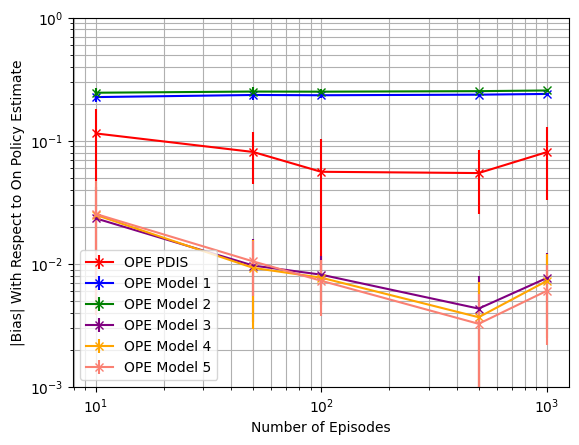

In [ ]:
bias_means = np.zeros((5,7))
bias_stds = np.zeros((5,7))

bias_means[:, 0] = bias_means_m1[:, 0]
bias_stds[:, 0] = bias_stds_m1[:, 0]

bias_means[:, 1] = bias_means_m1[:, 1]
bias_stds[:, 1] = bias_stds_m1[:, 1]

bias_means[:, 2] = bias_means_m1[:, 2]
bias_stds[:, 2] = bias_stds_m1[:, 2]

bias_means[:, 3] = bias_means_m2[:, 2]
bias_stds[:, 3] = bias_stds_m2[:, 2]

bias_means[:, 4] = bias_means_m3[:, 2]
bias_stds[:, 4] = bias_stds_m3[:, 2]

bias_means[:, 5] = bias_means_m4[:, 2]
bias_stds[:, 5] = bias_stds_m4[:, 2]

bias_means[:, 6] = bias_means_m5[:, 2]
bias_stds[:, 6] = bias_stds_m5[:, 2]

plot_graphs(bias_means, bias_stds, 'bias', 10**(-3), 10**0, estimator='neural-network')

### Variance

On Policy-----[0.03213233 0.00508809 0.00267309 0.00040398 0.00022806]
OPE PDIS-----[0.50301574 0.12765118 0.09864713 0.02477799 0.02464387]
OPE Model 1-----[0.00999267 0.00223871 0.00144033 0.00023729 0.0001368 ]
OPE Model 2-----[0.00905405 0.00219456 0.00132572 0.00022315 0.00013236]
OPE Model 3-----[8.03530351e-04 1.59792689e-04 9.88089697e-05 1.86744514e-05
 7.69073514e-06]
OPE Model 4-----[3.51291171e-04 5.83673743e-05 4.07698280e-05 5.80790552e-06
 2.19668044e-06]
OPE Model 5-----[3.52129523e-04 5.94721969e-05 4.11031917e-05 5.96786007e-06
 2.27505314e-06]


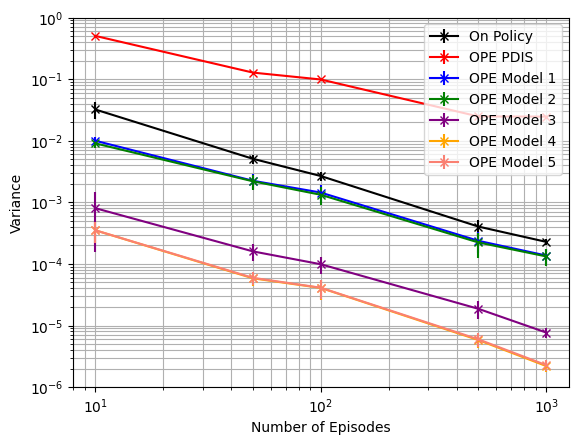

In [ ]:
var_means = np.zeros((5,7))
var_stds = np.zeros((5,7))

var_means[:, 0] = var_means_m1[:, 0]
var_stds[:, 0] = var_stds_m1[:, 0]

var_means[:, 1] = var_means_m1[:, 1]
var_stds_m1[:, 1] = var_stds_m1[:, 1]

var_means[:, 2] = var_means_m1[:, 2]
var_stds[:, 2] = var_stds_m1[:, 2]

var_means[:, 3] = var_means_m2[:, 2]
var_stds[:, 3] = var_stds_m2[:, 2]

var_means[:, 4] = var_means_m3[:, 2]
var_stds[:, 4] = var_stds_m3[:, 2]

var_means[:, 5] = var_means_m4[:, 2]
var_stds[:, 5] = var_stds_m4[:, 2]

var_means[:, 6] = var_means_m5[:, 2]
var_stds[:, 6] = var_stds_m5[:, 2]

plot_graphs(var_means, var_stds, 'var', 10**(-6), 10**0, estimator='neural-network')

### MSE

On Policy-----[0.03213233 0.00508809 0.00267309 0.00040398 0.00022806]
OPE PDIS-----[0.52067406 0.13553177 0.10410286 0.02860512 0.03344909]
OPE Model 1-----[0.061534   0.05798054 0.05632914 0.0561876  0.05763648]
OPE Model 2-----[0.06958373 0.06546335 0.06404103 0.06402922 0.06554814]
OPE Model 3-----[1.69598975e-03 2.94106803e-04 1.78146540e-04 5.10106182e-05
 8.82228423e-05]
OPE Model 4-----[1.42088119e-03 1.84289104e-04 1.09768896e-04 3.09546377e-05
 7.75953099e-05]
OPE Model 5-----[1.46665707e-03 1.93823921e-04 1.06819952e-04 2.24287061e-05
 5.34026971e-05]


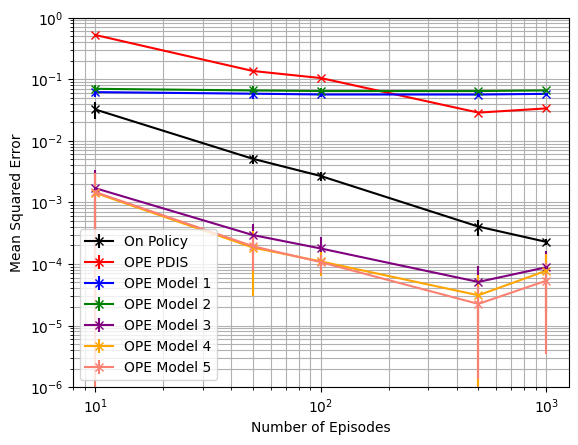

In [ ]:
mse_means = np.zeros((5,7))
mse_stds = np.zeros((5,7))

mse_means[:, 0] = mse_means_m1[:, 0]
mse_stds[:, 0] = mse_stds_m1[:, 0]

mse_means[:, 1] = mse_means_m1[:, 1]
mse_stds_m1[:, 1] = mse_stds_m1[:, 1]

mse_means[:, 2] = mse_means_m1[:, 2]
mse_stds[:, 2] = mse_stds_m1[:, 2]

mse_means[:, 3] = mse_means_m2[:, 2]
mse_stds[:, 3] = mse_stds_m2[:, 2]

mse_means[:, 4] = mse_means_m3[:, 2]
mse_stds[:, 4] = mse_stds_m3[:, 2]

mse_means[:, 5] = mse_means_m4[:, 2]
mse_stds[:, 5] = mse_stds_m4[:, 2]

mse_means[:, 6] = mse_means_m5[:, 2]
mse_stds[:, 6] = mse_stds_m5[:, 2]

plot_graphs(mse_means, mse_stds, 'MSE', 10**(-6), 10**0, estimator='neural-network')

### ESS

On Policy-----[  10.   50.  100.  500. 1000.]
OPE PDIS-----[ 0.74194103  2.90522078  4.90847825  9.68162662 22.99544418]
OPE Model 1-----[  31.64172795  128.53100739  209.2052971   947.4608577  1857.81026119]
OPE Model 2-----[  34.7794267   132.93676461  223.08203232 1071.72071609 1958.16625589]
OPE Model 3-----[  548.16041205  1758.89428915  2977.66650954 11446.42950478
 30493.95080888]
OPE Model 4-----[  1029.26918449   4565.18714256   7752.18944474  38779.43899056
 107656.82462398]
OPE Model 5-----[  1033.20842822   4493.98277084   7623.14277222  37555.61464424
 104733.30071053]


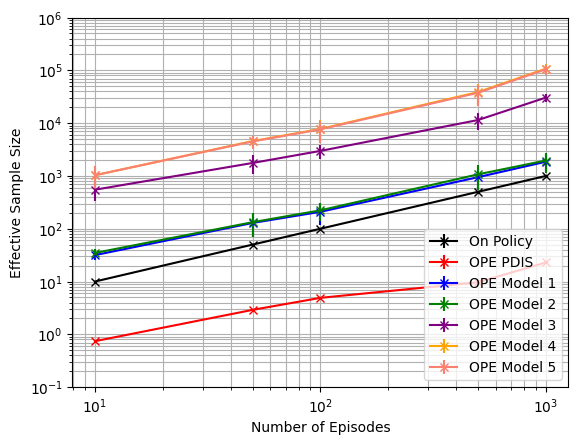

In [ ]:
ess_means = np.zeros((5,7))
ess_stds = np.zeros((5,7))

ess_means[:, 0] = ess_means_m1[:, 0]
ess_stds[:, 0] = ess_stds_m1[:, 0]

ess_means[:, 1] = ess_means_m1[:, 1]
ess_stds_m1[:, 1] = ess_stds_m1[:, 1]

ess_means[:, 2] = ess_means_m1[:, 2]
ess_stds[:, 2] = ess_stds_m1[:, 2]

ess_means[:, 3] = ess_means_m2[:, 2]
ess_stds[:, 3] = ess_stds_m2[:, 2]

ess_means[:, 4] = ess_means_m3[:, 2]
ess_stds[:, 4] = ess_stds_m3[:, 2]

ess_means[:, 5] = ess_means_m4[:, 2]
ess_stds[:, 5] = ess_stds_m4[:, 2]

ess_means[:, 6] = ess_means_m5[:, 2]
ess_stds[:, 6] = ess_stds_m5[:, 2]

plot_graphs(ess_means, ess_stds, 'ESS', 10**(-1), 10**6, estimator='neural-network')

# Test NN Trained on Patient State 136 Without Diabetes Tested on Data From State 136 With Diabetes

In [ ]:
#The patient has diabetes
PROB_DIAB = 0.0

### Varying Episodes $\epsilon_{e} = 0.4$ (Policy Divergence $4.8^{20}$)

Set up evaluation policy, generate data and convert into factored format

In [ ]:
EVAL_EPSILON = 0.4

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
# Calculate policy divergence from Voloshin et al.
D = 0
for state in range(randPol.shape[0] - 1):
    for action in range(randPol.shape[1] - 1):
        difference = evalPolSoft[state, action]/randPol[state, action]
        D = max(D, difference)
print(D)
shorter_D = round(D,2)

4.8


In [ ]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=evalPolSoft, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_e = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_e.shape

(100000, 20, 5)

In [ ]:
print(nf_tr_e)

[[[  0. 136.   6.   0. 141.]
  [  1. 141.   0.   0. 136.]
  [  2. 136.   3.   0. 219.]
  ...
  [ 17. 219.   3.   0. 219.]
  [ 18. 219.   3.   0. 219.]
  [ 19. 219.   3.   0. 219.]]

 [[  0. 136.   1.   0. 218.]
  [  1. 218.   5.   0. 142.]
  [  2. 142.   3.   0. 219.]
  ...
  [ 17. 367.   6.   0. 365.]
  [ 18. 365.   4.   0. 364.]
  [ 19. 364.   4.   0. 364.]]

 [[  0. 136.   3.   0. 139.]
  [  1. 139.   1.   0. 138.]
  [  2. 138.   5.   0. 222.]
  ...
  [ 17. 143.   2.   0. 137.]
  [ 18. 137.   6.   0. 141.]
  [ 19. 141.   3.   0. 219.]]

 ...

 [[  0. 136.   4.   0. 140.]
  [  1. 140.   3.   0. 219.]
  [  2. 219.   4.   0. 140.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   3.   0. 219.]
  [  1. 219.   3.   0. 219.]
  [  2. 219.   2.   0. 137.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   3.   0. 219.]
  [  1. 219.   5.   0. 222.]
  [  2. 222.   7.   0. 223

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


Run the data generator to generate behaviour policy data

In [ ]:
randPol = np.ones(fullPol.shape)/(fullPol.shape[1])

dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=randPol, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

Convert data into array format

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_b = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_b.shape

(100000, 20, 5)

In [ ]:
def pred_model_sa(model, test_data, *args):
  model.eval()
  mean = torch.zeros((1), dtype=torch.float32).to(device)
  for run in range(test_data.shape[0]):
    episode = test_data[run, :, :]
    #Filter out -1 states and actions
    episode = episode[episode[:, 2] != -1, :]
    states_and_actions = torch.as_tensor(episode[:, 1:3], dtype=torch.float32).to(device)
    # Compute prediction and loss
    factored_pol_reward = model(states_and_actions) #Use predictions from network to calculate OPE estimates
    D = list(factored_pol_reward.size())[-1]//3
    factored_pi_b = factored_pol_reward[:, :D]
    factored_pi_e = factored_pol_reward[:, D:2*D]
    factored_reward = factored_pol_reward[:, 2*D:]

    pointwise_IS_ratios = torch.div(factored_pi_e, factored_pi_b)
    IS_ratios = torch.prod(pointwise_IS_ratios, 0)

    times = torch.as_tensor(np.repeat(np.expand_dims(episode[:, 0], axis=1), D, axis=1)).to(device)
    # Per-trajectory returns (discounted cumulative rewards)
    gamma = torch.full(times.shape, DISCOUNT_Pol).to(device)
    G = torch.mul(factored_reward, torch.pow(gamma, times)).sum()

    mean.to(device)
    mean = torch.add(mean, G.div(test_data.shape[0]))
  return mean.to('cpu')

In [ ]:
def pred_model_rp(model, test_data, pi_b, pi_e, discount_factor):
  model.eval()
  mean = torch.zeros((1), dtype=torch.float32).to(device)
  for run in range(test_data.shape[0]):
    episode = test_data[run, :, :]
    #Filter out -1 states and actions
    episode = episode[episode[:, 2] != -1, :]
    S = episode[:, 1].astype('int32')
    A = episode[:,2].astype('int32')
    states_and_actions = torch.as_tensor(np.stack((pi_b[S, A], pi_e[S, A], episode[:,3]), axis=-1), dtype=torch.float32).to(device)
    # Compute prediction and loss
    factored_pol_reward = model(states_and_actions) #Use predictions from network to calculate OPE estimates
    D = list(factored_pol_reward.size())[-1]//3
    factored_pi_b = factored_pol_reward[:, :D]
    factored_pi_e = factored_pol_reward[:, D:2*D]
    factored_reward = factored_pol_reward[:, 2*D:]

    pointwise_IS_ratios = torch.div(factored_pi_e, factored_pi_b)
    IS_ratios = torch.prod(pointwise_IS_ratios, 0)

    times = torch.as_tensor(np.repeat(np.expand_dims(episode[:, 0], axis=1), D, axis=1)).to(device)
    # Per-trajectory returns (discounted cumulative rewards)
    gamma = torch.full(times.shape, discount_factor).to(device)
    G = torch.mul(factored_reward, torch.pow(gamma, times)).sum()

    mean.to(device)
    mean = torch.add(mean, G.div(test_data.shape[0]))
  return mean.to('cpu')

## Load Models

In [ ]:
#Takes in action and state
class FactorNetwork_sa(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 3*D),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
#Takes in policy values and reward at state and action
class FactorNetwork_pr(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 3*D),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

### Run any one of the below cells

In [ ]:
model = FactorNetwork_sa(2)
model.load_state_dict(torch.load('./model1e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_sa
label = 'Model 1'

In [ ]:
model = FactorNetwork_sa(3)
model.load_state_dict(torch.load('./model2e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_sa
label = 'Model 2'

In [ ]:
model = FactorNetwork_pr(2)
model.load_state_dict(torch.load('./model3e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_rp
label = 'Model 3'

In [ ]:
model = FactorNetwork_pr(3)
model.load_state_dict(torch.load('./model4e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_rp
label = 'Model 4'

In [ ]:
model = FactorNetwork_pr(4)
model.load_state_dict(torch.load('./model5e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_rp
label = 'Model 5'

## Generate data for model

In [ ]:
import policy_estimators as pe
import gc

def evaluate_PE(RUNS, EPISODES, label, STEPS=NSTEPS):

  biases = np.zeros((5,3))
  variances = np.zeros((5,3))
  MSEs = np.zeros((5,3))
  ESSs = np.zeros((5,3))

  # Reshape data for processing
  T, ldim = nf_tr_b.shape[-2], nf_tr_b.shape[-1]
  nfb = nf_tr_b.reshape((-1, RUNS, EPISODES, T, ldim))
  nfe = nf_tr_e.reshape((-1, RUNS, EPISODES, T, ldim))

  for t in range(5):
    print()

    lower_index = 0
    estimates_on_policy = np.zeros(RUNS)
    estimates_OPE_PDIS = np.zeros(RUNS)
    estimates_nn = np.zeros(RUNS)

    for r in range(RUNS):
        #On policy Q estimate
        estimates_on_policy[r] = pe.on_policy_Q_estimate(nfe[t, r, :, :STEPS, :], DISCOUNT_Pol)
        #Off policy PDIS estimate
        estimates_OPE_PDIS[r] = pe.off_policy_PDIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)
        #Off policy IS estimate
        estimates_nn[r] = func(model, nfb[t, r, :, :STEPS, :], randPol, evalPolSoft, DISCOUNT_Pol)

    mean_on_policy = np.mean(estimates_on_policy)
    var_on_policy = np.var(estimates_on_policy, ddof=0)
    print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

    from sklearn.metrics import mean_squared_error

    #For on policy
    biases[t, 0] = 0.0
    variances[t, 0] = var_on_policy
    MSEs[t, 0] = var_on_policy
    ESSs[t, 0] = EPISODES

    def generate_results(estimates, mean_true, label):
      MSE = mean_squared_error(estimates, [mean_true]*RUNS)
      mean = np.mean(estimates)
      var = np.var(estimates, ddof=0)
      bias1 = np.sqrt(MSE - var)
      bias2 = abs(mean - mean_true)
      print(f'Mean {label} estimate: {mean}. Bias1: {bias1}. Bias2: {bias2}. Variance: {var}. MSE: {MSE}')
      return bias1, var, MSE

    label_list = ['OPE PDIS', label]

    estimates = [estimates_OPE_PDIS, estimates_nn]

    for (id, val) in enumerate(label_list):
      biases[t, 1+id], variances[t, 1+id], MSEs[t, 1+id] = generate_results(estimates[id], mean_on_policy, label_list[id])
      ESSs[t, 1+id] = (EPISODES*variances[t, 0])/variances[t, 1+id]
      gc.collect()

  return np.mean(biases, axis=0), np.std(biases, axis=0), np.mean(variances, axis=0), np.std(variances, axis=0), np.mean(MSEs, axis=0), np.std(MSEs, axis=0), np.mean(ESSs, axis=0), np.std(ESSs, axis=0)

In [ ]:
EPISODES = [10, 50, 100, 500, 1000]

bias_means = np.zeros((len(EPISODES), 3))
bias_stds = np.zeros((len(EPISODES), 3))
var_means = np.zeros((len(EPISODES), 3))
var_stds = np.zeros((len(EPISODES), 3))
MSE_means = np.zeros((len(EPISODES), 3))
MSE_stds = np.zeros((len(EPISODES), 3))
ESS_means = np.zeros((len(EPISODES), 3))
ESS_stds = np.zeros((len(EPISODES), 3))

RUNS = 20

for id in range(len(EPISODES)):
  e = EPISODES[id]
  print(f'{e} Episodes, {RUNS} ----------------------------------')
  bias_means[id, :], bias_stds[id, :], var_means[id, :], var_stds[id, :], MSE_means[id, :], MSE_stds[id, :], ESS_means[id, :], ESS_stds[id, :] = evaluate_PE(RUNS=RUNS, EPISODES=e, label=label)
  print()
  gc.collect()

transform = lambda arr :list(map(list, arr))

print('BIAS MEANS')
print(transform(bias_means))
print('\nBIAS STDS')
print(transform(bias_stds))
print('\nVAR MEANS')
print(transform(var_means))
print('\nVAR STDS')
print(transform(var_stds))
print('\nMSE MEANS')
print(transform(MSE_means))
print('\nMSE STDS')
print(transform(MSE_stds))
print('\nESS MEANS')
print(transform(ESS_means))
print('\nESS STDS')
print(transform(ESS_stds))

10 Episodes, 20 ----------------------------------

Mean on policy Q estimate: -0.35217870641989946. Variance of on policy Q estimate: 0.04598026082075695
Mean OPE PDIS estimate: -0.3024892233300071. Bias1: 0.04968948308989225. Bias2: 0.04968948308989235. Variance: 0.3379570127408534. MSE: 0.34042605747059407
Mean Model 5 estimate: -0.7917061954736709. Bias1: 0.4395274890537715. Bias2: 0.4395274890537715. Variance: 0.002289812910529774. MSE: 0.195474226544443

Mean on policy Q estimate: -0.33787628292052296. Variance of on policy Q estimate: 0.02695329293362427
Mean OPE PDIS estimate: -0.3174196272922252. Bias1: 0.020456655628296603. Bias2: 0.020456655628297737. Variance: 0.24781183315908484. MSE: 0.24823030791857956
Mean Model 5 estimate: -0.8128890693187714. Bias1: 0.4750127863982484. Bias2: 0.4750127863982484. Variance: 0.0018265784509837956. MSE: 0.22746372569281176

Mean on policy Q estimate: -0.3425008593312468. Variance of on policy Q estimate: 0.03982103258053585
Mean OPE PDIS 

## Record Data

### Model 1

In [ ]:
bias_means_m1 = np.array([[0.0, 0.09300954129839964, 0.9927911928674025], [0.0, 0.09365627277279368, 0.9805881452720685], [0.0, 0.10338362910790408, 1.0068815310891968], [0.0, 0.1127017789128288, 1.0085984346635666], [0.0, 0.14976200766754727, 1.0056598745633252]])


bias_stds_m1 = np.array([[0.0, 0.0545053183542062, 0.06252929303087362], [0.0, 0.07528874298465812, 0.033423537404190545], [0.0, 0.06777339048628854, 0.031095350626388466], [0.0, 0.1003844606436182, 0.008345164077154509], [0.0, 0.1534771108026799, 0.007919703097286632]])


var_means_m1 = np.array([[0.03557068671747587, 0.31681073910511504, 0.07298903640939366], [0.01032987626405866, 0.3021501887341041, 0.01111879114656152], [0.004381503819904814, 0.20416906270218133, 0.006316742361898428], [0.000651730551487344, 0.332019567022975, 0.0016276850280367654], [0.00035123556285683263, 1.3424220201535124, 0.0008028210715444785]])


var_stds_m1 = np.array([[0.0067281767547962045, 0.20913188667590957, 0.005439681127267056], [0.004035218738914973, 0.3270792009217412, 0.0030497061204498807], [0.0008843060552925262, 0.1286277256370766, 0.002043040331848675], [0.00028356881274906986, 0.3327016283542181, 0.0005729485374443339], [8.741687586001064e-05, 2.462892716775451, 0.00045848082603418066]])


mse_means_m1 = np.array([[0.03557068671747587, 0.32843234360654716, 1.0625333015314147], [0.01032987626405866, 0.31659008098400593, 0.9737890346472863], [0.004381503819904814, 0.21945046992770897, 1.0210940808410016], [0.000651730551487344, 0.3547982979318013, 1.018968129197308], [0.00035123556285683263, 1.388405902634465, 1.0122173260754166]])


mse_stds_m1 = np.array([[0.0067281767547962045, 0.21068237003992815, 0.1249156607008861], [0.004035218738914973, 0.3408115854037431, 0.06590391212225129], [0.0008843060552925262, 0.14158017801626957, 0.06304398092102736], [0.00028356881274906986, 0.3661884292084861, 0.017131659778960966], [8.741687586001064e-05, 2.5365900067933316, 0.01630510166681385]])


ess_means_m1 = np.array([[10.0, 1.7455757083039323, 4.9443212245553525], [50.0, 5.745117514784267, 48.59931645695432], [100.0, 5.184765060496871, 79.11936079336398], [500.0, 3.8232511388869477, 243.89728788179627], [1000.0, 3.902509947984469, 672.6775611032151]])


ess_stds_m1 = np.array([[0.0, 1.312555421600297, 1.2484439798454396], [0.0, 6.521171652276982, 18.806652634465678], [0.0, 5.306031572423603, 31.18688607811516], [0.0, 3.421966388572557, 169.52127122454237], [0.0, 3.192571523881646, 462.71769464493144]])

### Model 2

In [ ]:
bias_means_m2 = np.array([[0.0, 0.09300954129839964, 0.9682431182643219], [0.0, 0.09365627277279368, 0.9568250608604474], [0.0, 0.10338362910790408, 0.9827465995248656], [0.0, 0.1127017789128288, 0.9838398108251418], [0.0, 0.14976200766754727, 0.9811221109677442]])


bias_stds_m2 = np.array([[0.0, 0.0545053183542062, 0.059235212400401076], [0.0, 0.07528874298465812, 0.032602042722408395], [0.0, 0.06777339048628854, 0.030511903458411052], [0.0, 0.1003844606436182, 0.007816915056463777], [0.0, 0.1534771108026799, 0.007529913259931742]])


var_means_m2 = np.array([[0.03557068671747587, 0.31681073910511504, 0.07319277885994865], [0.01032987626405866, 0.3021501887341041, 0.010986494010179357], [0.004381503819904814, 0.20416906270218133, 0.006216936889748929], [0.000651730551487344, 0.332019567022975, 0.0015509607024313892], [0.00035123556285683263, 1.3424220201535124, 0.0007699855767450785]])


var_stds_m2 = np.array([[0.0067281767547962045, 0.20913188667590957, 0.011457982031618142], [0.004035218738914973, 0.3270792009217412, 0.0020289531133644025], [0.0008843060552925262, 0.1286277256370766, 0.0020186111931282218], [0.00028356881274906986, 0.3327016283542181, 0.0005269243110479106], [8.741687586001064e-05, 2.462892716775451, 0.00041029008846056657]])


mse_means_m2 = np.array([[0.03557068671747587, 0.32843234360654716, 1.0141963253142867], [0.01032987626405866, 0.31659008098400593, 0.927563584290452], [0.004381503819904814, 0.21945046992770897, 0.972938792020091], [0.000651730551487344, 0.3547982979318013, 0.9695528382278823], [0.00035123556285683263, 1.388405902634465, 0.9634272818002497]])


mse_stds_m2 = np.array([[0.0067281767547962045, 0.21068237003992815, 0.11795655218651373], [0.004035218738914973, 0.3408115854037431, 0.06216976973711807], [0.0008843060552925262, 0.14158017801626957, 0.06030226195889301], [0.00028356881274906986, 0.3661884292084861, 0.01570898689678154], [8.741687586001064e-05, 2.5365900067933316, 0.015109772194098073]])


ess_means_m2 = np.array([[10.0, 1.7455757083039323, 5.120984297407436], [50.0, 5.745117514784267, 47.69832887005418], [100.0, 5.184765060496871, 79.94090840305088], [500.0, 3.8232511388869477, 246.09780233720775], [1000.0, 3.902509947984469, 668.3244805484694]])


ess_stds_m2 = np.array([[0.0, 1.312555421600297, 1.8273461722806752], [0.0, 6.521171652276982, 18.009935157485174], [0.0, 5.306031572423603, 30.31656691144727], [0.0, 3.421966388572557, 149.12719975359676], [0.0, 3.192571523881646, 447.56031408861276]])

### Model 3

In [ ]:
bias_means_m3 = np.array([[0.0, 0.09300954129839964, 0.4586896095057769], [0.0, 0.09365627277279368, 0.45436737956219153], [0.0, 0.10338362910790408, 0.45980649670923757], [0.0, 0.1127017789128288, 0.46284977529123683], [0.0, 0.14976200766754727, 0.4609928165722974]])


bias_stds_m3 = np.array([[0.0, 0.0545053183542062, 0.016450937601659138], [0.0, 0.07528874298465812, 0.020532340901945084], [0.0, 0.06777339048628854, 0.011929848210739065], [0.0, 0.1003844606436182, 0.0024622741168208117], [0.0, 0.1534771108026799, 0.004997175961637311]])


var_means_m3 = np.array([[0.03557068671747587, 0.31681073910511504, 0.003461205892269648], [0.01032987626405866, 0.3021501887341041, 0.0006609220844578143], [0.004381503819904814, 0.20416906270218133, 0.00038880196131658805], [0.000651730551487344, 0.332019567022975, 6.474127373213179e-05], [0.00035123556285683263, 1.3424220201535124, 3.272584702112624e-05]])


var_stds_m3 = np.array([[0.0067281767547962045, 0.20913188667590957, 0.0016436456091342502], [0.004035218738914973, 0.3270792009217412, 0.00023158945805059518], [0.0008843060552925262, 0.1286277256370766, 0.00015384319688260492], [0.00028356881274906986, 0.3327016283542181, 1.5248844427252444e-05], [8.741687586001064e-05, 2.462892716775451, 8.360160535919884e-06]])


mse_means_m3 = np.array([[0.03557068671747587, 0.32843234360654716, 0.2141279971088054], [0.01032987626405866, 0.31659008098400593, 0.20753221471758412], [0.004381503819904814, 0.21945046992770897, 0.21195313765567003], [0.000651730551487344, 0.3547982979318013, 0.21430071855470695], [0.00035123556285683263, 1.388405902634465, 0.2125720745458725]])


mse_stds_m3 = np.array([[0.0067281767547962045, 0.21068237003992815, 0.015616198672192345], [0.004035218738914973, 0.3408115854037431, 0.01843078593649361], [0.0008843060552925262, 0.14158017801626957, 0.01089941308207863], [0.00028356881274906986, 0.3661884292084861, 0.002277693478772271], [8.741687586001064e-05, 2.5365900067933316, 0.0046102282282725416]])


ess_means_m3 = np.array([[10.0, 1.7455757083039323, 134.42503071212224], [50.0, 5.745117514784267, 994.5841206378831], [100.0, 5.184765060496871, 1529.1573657202566], [500.0, 3.8232511388869477, 5004.8712358722505], [1000.0, 3.902509947984469, 11166.824434061717]])


ess_stds_m3 = np.array([[0.0, 1.312555421600297, 74.5628201611172], [0.0, 6.521171652276982, 730.4409243722041], [0.0, 5.306031572423603, 1107.758219164159], [0.0, 3.421966388572557, 1691.456333450049], [0.0, 3.192571523881646, 3169.8259431613283]])

### Model 4

In [ ]:
bias_means_m4 = np.array([[0.0, 0.09300954129839964, 0.45675285492146445], [0.0, 0.09365627277279368, 0.4503085571687741], [0.0, 0.10338362910790408, 0.456193769782434], [0.0, 0.1127017789128288, 0.458764261937889], [0.0, 0.14976200766754727, 0.4573567353535779]])


bias_stds_m4 = np.array([[0.0, 0.0545053183542062, 0.023454829983938996], [0.0, 0.07528874298465812, 0.017870481097892035], [0.0, 0.06777339048628854, 0.00930081853247536], [0.0, 0.1003844606436182, 0.00226659476940238], [0.0, 0.1534771108026799, 0.0042561459021991654]])


var_means_m4 = np.array([[0.03557068671747587, 0.31681073910511504, 0.002103316820336765], [0.01032987626405866, 0.3021501887341041, 0.00034543094528295096], [0.004381503819904814, 0.20416906270218133, 0.00019818979745415177], [0.000651730551487344, 0.332019567022975, 4.059552029526615e-05], [0.00035123556285683263, 1.3424220201535124, 1.7914372314447035e-05]])


var_stds_m4 = np.array([[0.0067281767547962045, 0.20913188667590957, 0.0007489236901567001], [0.004035218738914973, 0.3270792009217412, 0.00011491161471782007], [0.0008843060552925262, 0.1286277256370766, 7.436258775452298e-05], [0.00028356881274906986, 0.3327016283542181, 1.4022532133604656e-05], [8.741687586001064e-05, 2.462892716775451, 6.92167839004102e-06]])


mse_means_m4 = np.array([[0.03557068671747587, 0.32843234360654716, 0.21127661634882058], [0.01032987626405866, 0.31659008098400593, 0.20344258169937618], [0.004381503819904814, 0.21945046992770897, 0.20839745061113663], [0.000651730551487344, 0.3547982979318013, 0.21051038100356], [0.00035123556285683263, 1.388405902634465, 0.20921121252353797]])


mse_stds_m4 = np.array([[0.0067281767547962045, 0.21068237003992815, 0.022131685021533044], [0.004035218738914973, 0.3408115854037431, 0.015875282090467072], [0.0008843060552925262, 0.14158017801626957, 0.008443763779501], [0.00028356881274906986, 0.3661884292084861, 0.0020706118239021], [8.741687586001064e-05, 2.5365900067933316, 0.0038991846347550397]])


ess_means_m4 = np.array([[10.0, 1.7455757083039323, 195.39513140315222], [50.0, 5.745117514784267, 1806.7002872629364], [100.0, 5.184765060496871, 2709.2441651092404], [500.0, 3.8232511388869477, 8746.343039369123], [1000.0, 3.902509947984469, 21164.606674200575]])


ess_stds_m4 = np.array([[0.0, 1.312555421600297, 83.8219715310059], [0.0, 6.521171652276982, 1184.7782599772163], [0.0, 5.306031572423603, 1401.1390088291914], [0.0, 3.421966388572557, 3201.146449607981], [0.0, 3.192571523881646, 4950.325539447474]])

### Model 5

In [ ]:
bias_means_m5 = np.array([[0.0, 0.09300954129839964, 0.4618253687402053], [0.0, 0.09365627277279368, 0.4550900685947461], [0.0, 0.10338362910790408, 0.46092856308783103], [0.0, 0.1127017789128288, 0.4635082736976471], [0.0, 0.14976200766754727, 0.4621283392954954]])


bias_stds_m5 = np.array([[0.0, 0.0545053183542062, 0.0241632794370424], [0.0, 0.07528874298465812, 0.017656760051337272], [0.0, 0.06777339048628854, 0.009190011166208253], [0.0, 0.1003844606436182, 0.0022378701853596815], [0.0, 0.1534771108026799, 0.004217377965998576]])


var_means_m5 = np.array([[0.03557068671747587, 0.31681073910511504, 0.002134584195587781], [0.01032987626405866, 0.3021501887341041, 0.00033940794864864186], [0.004381503819904814, 0.20416906270218133, 0.00019073717027787927], [0.000651730551487344, 0.332019567022975, 4.0243922115253736e-05], [0.00035123556285683263, 1.3424220201535124, 1.7327736132047634e-05]])


var_stds_m5 = np.array([[0.0067281767547962045, 0.20913188667590957, 0.0007600450098864248], [0.004035218738914973, 0.3270792009217412, 0.00011508118947234227], [0.0008843060552925262, 0.1286277256370766, 7.295585058525556e-05], [0.00028356881274906986, 0.3327016283542181, 1.4460844834754992e-05], [8.741687586001064e-05, 2.462892716775451, 6.522132475162236e-06]])


mse_means_m5 = np.array([[0.03557068671747587, 0.32843234360654716, 0.21600111948076695], [0.01032987626405866, 0.31659008098400593, 0.20775813965772988], [0.004381503819904814, 0.21945046992770897, 0.21273033374572553], [0.000651730551487344, 0.3547982979318013, 0.21488517177125468], [0.00035123556285683263, 1.388405902634465, 0.2135977159930526]])


mse_stds_m5 = np.array([[0.0067281767547962045, 0.21068237003992815, 0.023117666896777318], [0.004035218738914973, 0.3408115854037431, 0.01587756624024478], [0.0008843060552925262, 0.14158017801626957, 0.008432283157748617], [0.00028356881274906986, 0.3661884292084861, 0.0020657772621420233], [8.741687586001064e-05, 2.5365900067933316, 0.0039044710843136148]])


ess_means_m5 = np.array([[10.0, 1.7455757083039323, 190.7765764096545], [50.0, 5.745117514784267, 1826.2596464038093], [100.0, 5.184765060496871, 2828.6247916497414], [500.0, 3.8232511388869477, 8932.983335310468], [1000.0, 3.902509947984469, 21699.99208557173]])


ess_stds_m5 = np.array([[0.0, 1.312555421600297, 77.31775459381895], [0.0, 6.521171652276982, 1160.5490905614931], [0.0, 5.306031572423603, 1467.6385890705692], [0.0, 3.421966388572557, 3410.457092926819], [0.0, 3.192571523881646, 4910.159336017288]])

## Plot Graphs

In [ ]:
import pickle
import matplotlib.pyplot as plt

def plot_graphs(means, stds, label, low_ylim, up_ylim, estimator='IS'):
  EPISODES = [10, 50, 100, 500, 1000]

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error',
      'ESS': 'Effective Sample Size'
  }

  colours = {
      'On Policy': 'k',
      'OPE PDIS': 'r',
      'OPE Model 1': 'b',
      'OPE Model 2': 'g',
      'OPE Model 3': 'purple',
      'OPE Model 4': 'orange',
      'OPE Model 5': 'salmon'
  }

  legend_list = ['OPE PDIS',
                   'OPE Model 1',
                   'OPE Model 2',
                   'OPE Model 3',
                   'OPE Model 4',
                   'OPE Model 5']

  index_list = [1,2,3,4,5,6]

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
    index_list.insert(0, 0)
  for (id, legend) in zip(index_list, legend_list):
    print(f'{legend}-----{means[:, id]}')
    plt.errorbar(EPISODES, means[:, id], yerr=stds[:, id], color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Number of Episodes')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-NN-136D-136ND-{estimator}.pdf', dpi=300)
  plt.show()


### Bias

OPE PDIS-----[0.09300954 0.09365627 0.10338363 0.11270178 0.14976201]
OPE Model 1-----[0.99279119 0.98058815 1.00688153 1.00859843 1.00565987]
OPE Model 2-----[0.96824312 0.95682506 0.9827466  0.98383981 0.98112211]
OPE Model 3-----[0.45868961 0.45436738 0.4598065  0.46284978 0.46099282]
OPE Model 4-----[0.45675285 0.45030856 0.45619377 0.45876426 0.45735674]
OPE Model 5-----[0.46182537 0.45509007 0.46092856 0.46350827 0.46212834]


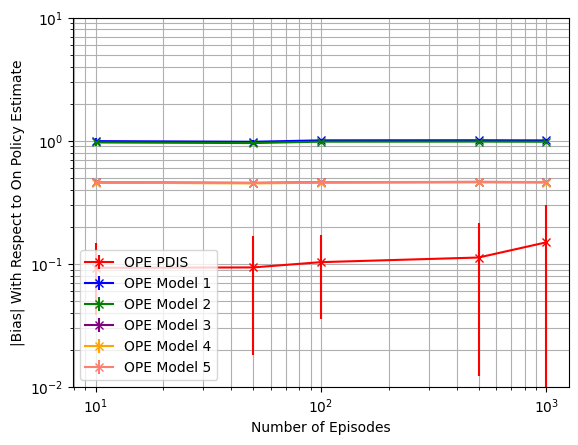

In [ ]:
bias_means = np.zeros((5,7))
bias_stds = np.zeros((5,7))

bias_means[:, 0] = bias_means_m1[:, 0]
bias_stds[:, 0] = bias_stds_m1[:, 0]

bias_means[:, 1] = bias_means_m1[:, 1]
bias_stds[:, 1] = bias_stds_m1[:, 1]

bias_means[:, 2] = bias_means_m1[:, 2]
bias_stds[:, 2] = bias_stds_m1[:, 2]

bias_means[:, 3] = bias_means_m2[:, 2]
bias_stds[:, 3] = bias_stds_m2[:, 2]

bias_means[:, 4] = bias_means_m3[:, 2]
bias_stds[:, 4] = bias_stds_m3[:, 2]

bias_means[:, 5] = bias_means_m4[:, 2]
bias_stds[:, 5] = bias_stds_m4[:, 2]

bias_means[:, 6] = bias_means_m5[:, 2]
bias_stds[:, 6] = bias_stds_m5[:, 2]

plot_graphs(bias_means, bias_stds, 'bias', 10**(-2), 10**1, estimator='neural-network')

### Variance

On Policy-----[0.03557069 0.01032988 0.0043815  0.00065173 0.00035124]
OPE PDIS-----[0.31681074 0.30215019 0.20416906 0.33201957 1.34242202]
OPE Model 1-----[0.07298904 0.01111879 0.00631674 0.00162769 0.00080282]
OPE Model 2-----[0.07319278 0.01098649 0.00621694 0.00155096 0.00076999]
OPE Model 3-----[3.46120589e-03 6.60922084e-04 3.88801961e-04 6.47412737e-05
 3.27258470e-05]
OPE Model 4-----[2.10331682e-03 3.45430945e-04 1.98189797e-04 4.05955203e-05
 1.79143723e-05]
OPE Model 5-----[2.13458420e-03 3.39407949e-04 1.90737170e-04 4.02439221e-05
 1.73277361e-05]


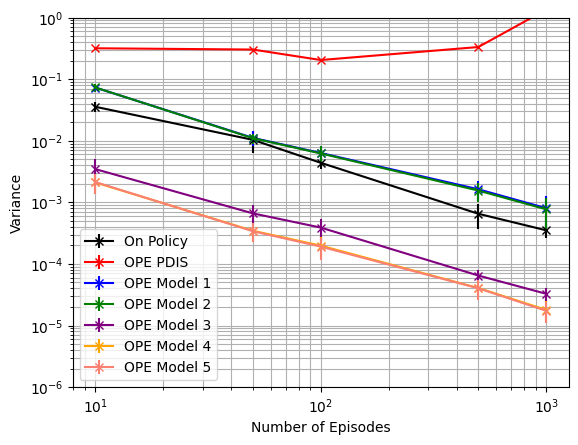

In [ ]:
var_means = np.zeros((5,7))
var_stds = np.zeros((5,7))

var_means[:, 0] = var_means_m1[:, 0]
var_stds[:, 0] = var_stds_m1[:, 0]

var_means[:, 1] = var_means_m1[:, 1]
var_stds_m1[:, 1] = var_stds_m1[:, 1]

var_means[:, 2] = var_means_m1[:, 2]
var_stds[:, 2] = var_stds_m1[:, 2]

var_means[:, 3] = var_means_m2[:, 2]
var_stds[:, 3] = var_stds_m2[:, 2]

var_means[:, 4] = var_means_m3[:, 2]
var_stds[:, 4] = var_stds_m3[:, 2]

var_means[:, 5] = var_means_m4[:, 2]
var_stds[:, 5] = var_stds_m4[:, 2]

var_means[:, 6] = var_means_m5[:, 2]
var_stds[:, 6] = var_stds_m5[:, 2]

plot_graphs(var_means, var_stds, 'var', 10**(-6), 10**0, estimator='neural-network')

### MSE

On Policy-----[0.03557069 0.01032988 0.0043815  0.00065173 0.00035124]
OPE PDIS-----[0.32843234 0.31659008 0.21945047 0.3547983  1.3884059 ]
OPE Model 1-----[1.0625333  0.97378903 1.02109408 1.01896813 1.01221733]
OPE Model 2-----[1.01419633 0.92756358 0.97293879 0.96955284 0.96342728]
OPE Model 3-----[0.214128   0.20753221 0.21195314 0.21430072 0.21257207]
OPE Model 4-----[0.21127662 0.20344258 0.20839745 0.21051038 0.20921121]
OPE Model 5-----[0.21600112 0.20775814 0.21273033 0.21488517 0.21359772]


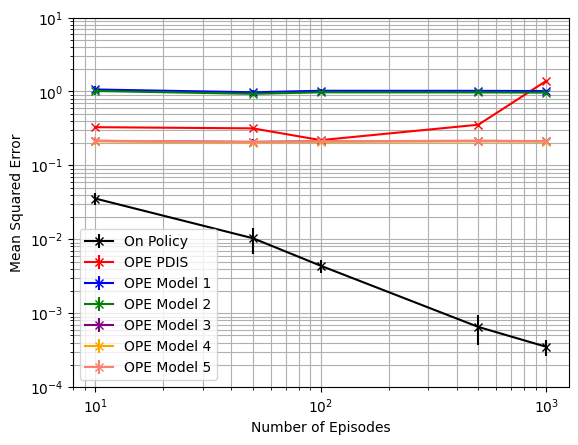

In [ ]:
mse_means = np.zeros((5,7))
mse_stds = np.zeros((5,7))

mse_means[:, 0] = mse_means_m1[:, 0]
mse_stds[:, 0] = mse_stds_m1[:, 0]

mse_means[:, 1] = mse_means_m1[:, 1]
mse_stds_m1[:, 1] = mse_stds_m1[:, 1]

mse_means[:, 2] = mse_means_m1[:, 2]
mse_stds[:, 2] = mse_stds_m1[:, 2]

mse_means[:, 3] = mse_means_m2[:, 2]
mse_stds[:, 3] = mse_stds_m2[:, 2]

mse_means[:, 4] = mse_means_m3[:, 2]
mse_stds[:, 4] = mse_stds_m3[:, 2]

mse_means[:, 5] = mse_means_m4[:, 2]
mse_stds[:, 5] = mse_stds_m4[:, 2]

mse_means[:, 6] = mse_means_m5[:, 2]
mse_stds[:, 6] = mse_stds_m5[:, 2]

plot_graphs(mse_means, mse_stds, 'MSE', 10**(-4), 10**1, estimator='neural-network')

### ESS

On Policy-----[  10.   50.  100.  500. 1000.]
OPE PDIS-----[1.74557571 5.74511751 5.18476506 3.82325114 3.90250995]
OPE Model 1-----[  4.94432122  48.59931646  79.11936079 243.89728788 672.6775611 ]
OPE Model 2-----[  5.1209843   47.69832887  79.9409084  246.09780234 668.32448055]
OPE Model 3-----[  134.42503071   994.58412064  1529.15736572  5004.87123587
 11166.82443406]
OPE Model 4-----[  195.3951314   1806.70028726  2709.24416511  8746.34303937
 21164.6066742 ]
OPE Model 5-----[  190.77657641  1826.2596464   2828.62479165  8932.98333531
 21699.99208557]


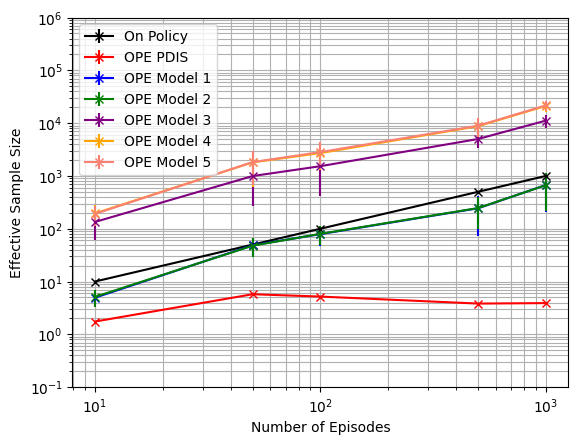

In [ ]:
ess_means = np.zeros((5,7))
ess_stds = np.zeros((5,7))

ess_means[:, 0] = ess_means_m1[:, 0]
ess_stds[:, 0] = ess_stds_m1[:, 0]

ess_means[:, 1] = ess_means_m1[:, 1]
ess_stds_m1[:, 1] = ess_stds_m1[:, 1]

ess_means[:, 2] = ess_means_m1[:, 2]
ess_stds[:, 2] = ess_stds_m1[:, 2]

ess_means[:, 3] = ess_means_m2[:, 2]
ess_stds[:, 3] = ess_stds_m2[:, 2]

ess_means[:, 4] = ess_means_m3[:, 2]
ess_stds[:, 4] = ess_stds_m3[:, 2]

ess_means[:, 5] = ess_means_m4[:, 2]
ess_stds[:, 5] = ess_stds_m4[:, 2]

ess_means[:, 6] = ess_means_m5[:, 2]
ess_stds[:, 6] = ess_stds_m5[:, 2]

plot_graphs(ess_means, ess_stds, 'ESS', 10**(-1), 10**6, estimator='neural-network')

# Test NN Trained on Patient State 136 With Diabetes Tested on Data From State 56 With Diabetes

In [ ]:
#The patient has diabetes
PROB_DIAB = 1.0

### Varying Episodes $\epsilon_{e} = 0.4$ (Policy Divergence $4.8^{20}$)

Set up evaluation policy, generate data and convert into factored format

In [ ]:
EVAL_EPSILON = 0.4

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
# Calculate policy divergence from Voloshin et al.
D = 0
for state in range(randPol.shape[0] - 1):
    for action in range(randPol.shape[1] - 1):
        difference = evalPolSoft[state, action]/randPol[state, action]
        D = max(D, difference)
print(D)
shorter_D = round(D,2)

4.8


In [ ]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=evalPolSoft, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_e = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_e.shape

(100000, 20, 5)

In [ ]:
print(nf_tr_e)

[[[  0.  56.   6.   0.  61.]
  [  1.  61.   0.  -1.  64.]
  [  2.  64.  -1.   0.  -1.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0.  56.   3.   0. 147.]
  [  1. 147.   4.   0. 140.]
  [  2. 140.   2.   0. 129.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0.  56.   3.   0. 219.]
  [  1. 219.   6.   0. 141.]
  [  2. 141.   2.   0. 145.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 ...

 [[  0.  56.   3.  -1. 227.]
  [  1. 227.  -1.   0.  -1.]
  [  2.  -1.  -1.   0.  -1.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0.  56.   3.   0. 379.]
  [  1. 379.   6.   0. 389.]
  [  2. 389.   0.   0. 384.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0.  56.   1.   0. 146.]
  [  1. 146.   2.  -1.  65.]
  [  2.  65.  -1.   0.  -1

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


Run the data generator to generate behaviour policy data

In [ ]:
randPol = np.ones(fullPol.shape)/(fullPol.shape[1])

dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=randPol, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

Convert data into array format

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_b = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_b.shape

(100000, 20, 5)

In [ ]:
def pred_model_sa(model, test_data, *args):
  model.eval()
  mean = torch.zeros((1), dtype=torch.float32).to(device)
  for run in range(test_data.shape[0]):
    episode = test_data[run, :, :]
    #Filter out -1 states and actions
    episode = episode[episode[:, 2] != -1, :]
    states_and_actions = torch.as_tensor(episode[:, 1:3], dtype=torch.float32).to(device)
    # Compute prediction and loss
    factored_pol_reward = model(states_and_actions) #Use predictions from network to calculate OPE estimates
    D = list(factored_pol_reward.size())[-1]//3
    factored_pi_b = factored_pol_reward[:, :D]
    factored_pi_e = factored_pol_reward[:, D:2*D]
    factored_reward = factored_pol_reward[:, 2*D:]

    pointwise_IS_ratios = torch.div(factored_pi_e, factored_pi_b)
    IS_ratios = torch.prod(pointwise_IS_ratios, 0)

    times = torch.as_tensor(np.repeat(np.expand_dims(episode[:, 0], axis=1), D, axis=1)).to(device)
    # Per-trajectory returns (discounted cumulative rewards)
    gamma = torch.full(times.shape, DISCOUNT_Pol).to(device)
    G = torch.mul(factored_reward, torch.pow(gamma, times)).sum()

    mean.to(device)
    mean = torch.add(mean, G.div(test_data.shape[0]))
  return mean.to('cpu')

In [ ]:
def pred_model_rp(model, test_data, pi_b, pi_e, discount_factor):
  model.eval()
  mean = torch.zeros((1), dtype=torch.float32).to(device)
  for run in range(test_data.shape[0]):
    episode = test_data[run, :, :]
    #Filter out -1 states and actions
    episode = episode[episode[:, 2] != -1, :]
    S = episode[:, 1].astype('int32')
    A = episode[:,2].astype('int32')
    states_and_actions = torch.as_tensor(np.stack((pi_b[S, A], pi_e[S, A], episode[:,3]), axis=-1), dtype=torch.float32).to(device)
    # Compute prediction and loss
    factored_pol_reward = model(states_and_actions) #Use predictions from network to calculate OPE estimates
    D = list(factored_pol_reward.size())[-1]//3
    factored_pi_b = factored_pol_reward[:, :D]
    factored_pi_e = factored_pol_reward[:, D:2*D]
    factored_reward = factored_pol_reward[:, 2*D:]

    pointwise_IS_ratios = torch.div(factored_pi_e, factored_pi_b)
    IS_ratios = torch.prod(pointwise_IS_ratios, 0)

    times = torch.as_tensor(np.repeat(np.expand_dims(episode[:, 0], axis=1), D, axis=1)).to(device)
    # Per-trajectory returns (discounted cumulative rewards)
    gamma = torch.full(times.shape, discount_factor).to(device)
    G = torch.mul(factored_reward, torch.pow(gamma, times)).sum()

    mean.to(device)
    mean = torch.add(mean, G.div(test_data.shape[0]))
  return mean.to('cpu')

## Load Models

In [ ]:
#Takes in action and state
class FactorNetwork_sa(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 3*D),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
#Takes in policy values and reward at state and action
class FactorNetwork_pr(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 3*D),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

### Run any one of the below cells

In [ ]:
model = FactorNetwork_sa(2)
model.load_state_dict(torch.load('./model1e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_sa
label = 'Model 1'

In [ ]:
model = FactorNetwork_sa(3)
model.load_state_dict(torch.load('./model2e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_sa
label = 'Model 2'

In [ ]:
model = FactorNetwork_pr(2)
model.load_state_dict(torch.load('./model3e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_rp
label = 'Model 3'

In [ ]:
model = FactorNetwork_pr(3)
model.load_state_dict(torch.load('./model4e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_rp
label = 'Model 4'

In [ ]:
model = FactorNetwork_pr(4)
model.load_state_dict(torch.load('./model5e004', map_location=torch.device('cpu')))
model.eval()
func = pred_model_rp
label = 'Model 5'

## Generate data for model

In [ ]:
import policy_estimators as pe
import gc

def evaluate_PE(RUNS, EPISODES, label, STEPS=NSTEPS):

  biases = np.zeros((5,3))
  variances = np.zeros((5,3))
  MSEs = np.zeros((5,3))
  ESSs = np.zeros((5,3))

  # Reshape data for processing
  T, ldim = nf_tr_b.shape[-2], nf_tr_b.shape[-1]
  nfb = nf_tr_b.reshape((-1, RUNS, EPISODES, T, ldim))
  nfe = nf_tr_e.reshape((-1, RUNS, EPISODES, T, ldim))

  for t in range(5):
    print()

    lower_index = 0
    estimates_on_policy = np.zeros(RUNS)
    estimates_OPE_PDIS = np.zeros(RUNS)
    estimates_nn = np.zeros(RUNS)

    for r in range(RUNS):
        #On policy Q estimate
        estimates_on_policy[r] = pe.on_policy_Q_estimate(nfe[t, r, :, :STEPS, :], DISCOUNT_Pol)
        #Off policy PDIS estimate
        estimates_OPE_PDIS[r] = pe.off_policy_PDIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)
        #Off policy IS estimate
        estimates_nn[r] = func(model, nfb[t, r, :, :STEPS, :], randPol, evalPolSoft, DISCOUNT_Pol)

    mean_on_policy = np.mean(estimates_on_policy)
    var_on_policy = np.var(estimates_on_policy, ddof=0)
    print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

    from sklearn.metrics import mean_squared_error

    #For on policy
    biases[t, 0] = 0.0
    variances[t, 0] = var_on_policy
    MSEs[t, 0] = var_on_policy
    ESSs[t, 0] = EPISODES

    def generate_results(estimates, mean_true, label):
      MSE = mean_squared_error(estimates, [mean_true]*RUNS)
      mean = np.mean(estimates)
      var = np.var(estimates, ddof=0)
      bias1 = np.sqrt(MSE - var)
      bias2 = abs(mean - mean_true)
      print(f'Mean {label} estimate: {mean}. Bias1: {bias1}. Bias2: {bias2}. Variance: {var}. MSE: {MSE}')
      return bias1, var, MSE

    label_list = ['OPE PDIS', label]

    estimates = [estimates_OPE_PDIS, estimates_nn]

    for (id, val) in enumerate(label_list):
      biases[t, 1+id], variances[t, 1+id], MSEs[t, 1+id] = generate_results(estimates[id], mean_on_policy, label_list[id])
      ESSs[t, 1+id] = (EPISODES*variances[t, 0])/variances[t, 1+id]
      gc.collect()

  return np.mean(biases, axis=0), np.std(biases, axis=0), np.mean(variances, axis=0), np.std(variances, axis=0), np.mean(MSEs, axis=0), np.std(MSEs, axis=0), np.mean(ESSs, axis=0), np.std(ESSs, axis=0)

In [ ]:
EPISODES = [10, 50, 100, 500, 1000]

bias_means = np.zeros((len(EPISODES), 3))
bias_stds = np.zeros((len(EPISODES), 3))
var_means = np.zeros((len(EPISODES), 3))
var_stds = np.zeros((len(EPISODES), 3))
MSE_means = np.zeros((len(EPISODES), 3))
MSE_stds = np.zeros((len(EPISODES), 3))
ESS_means = np.zeros((len(EPISODES), 3))
ESS_stds = np.zeros((len(EPISODES), 3))

RUNS = 20

for id in range(len(EPISODES)):
  e = EPISODES[id]
  print(f'{e} Episodes, {RUNS} ----------------------------------')
  bias_means[id, :], bias_stds[id, :], var_means[id, :], var_stds[id, :], MSE_means[id, :], MSE_stds[id, :], ESS_means[id, :], ESS_stds[id, :] = evaluate_PE(RUNS=RUNS, EPISODES=e, label=label)
  print()
  gc.collect()

transform = lambda arr :list(map(list, arr))

print('BIAS MEANS')
print(transform(bias_means))
print('\nBIAS STDS')
print(transform(bias_stds))
print('\nVAR MEANS')
print(transform(var_means))
print('\nVAR STDS')
print(transform(var_stds))
print('\nMSE MEANS')
print(transform(MSE_means))
print('\nMSE STDS')
print(transform(MSE_stds))
print('\nESS MEANS')
print(transform(ESS_means))
print('\nESS STDS')
print(transform(ESS_stds))

10 Episodes, 20 ----------------------------------

Mean on policy Q estimate: -0.8262654648637193. Variance of on policy Q estimate: 0.023394251878768733
Mean OPE PDIS estimate: -0.691777342531877. Bias1: 0.13448812233184196. Bias2: 0.13448812233184237. Variance: 0.24455052631568389. MSE: 0.26263758136402837
Mean Model 5 estimate: -0.7832296550273895. Bias1: 0.0430358098363298. Bias2: 0.04303580983632982. Variance: 0.00029249466160937495. MSE: 0.0021445755898781152

Mean on policy Q estimate: -0.8261033134570118. Variance of on policy Q estimate: 0.016685366384058736
Mean OPE PDIS estimate: -0.7951540447443248. Bias1: 0.0309492687126853. Bias2: 0.030949268712686995. Variance: 0.4344348275284192. MSE: 0.4353926847622692
Mean Model 5 estimate: -0.7828713417053222. Bias1: 0.04323197175168956. Bias2: 0.04323197175168958. Variance: 0.00023730929353554583. MSE: 0.00210631267507443

Mean on policy Q estimate: -0.8407303543869947. Variance of on policy Q estimate: 0.016300813097532077
Mean OP

## Record Data

### Model 1

In [ ]:
bias_means_m1 = np.array([[0.0, 0.1634525976130416, 0.2493439089231213], [0.0, 0.09278945317735138, 0.26809328022944007], [0.0, 0.10281549380097836, 0.267392156235411], [0.0, 0.06855782346909094, 0.2639622778023168], [0.0, 0.08638630081131576, 0.2653355018214948]])


bias_stds_m1 = np.array([[0.0, 0.1089255193169952, 0.04740650634078323], [0.0, 0.04073698097637516, 0.019454181797359946], [0.0, 0.04416105786265092, 0.013135438517163653], [0.0, 0.05340906123660401, 0.003240588609341996], [0.0, 0.09144918247965958, 0.002186020826555136]])


var_means_m1 = np.array([[0.019883699001011827, 0.4880180606731733, 0.01270633247558007], [0.0030447417472289585, 0.15911505227489697, 0.0033585530286471704], [0.0020108618755330563, 0.09560808874879709, 0.0015684480290036186], [0.0005062248064683011, 0.12876435574992925, 0.0002611867366716485], [0.00023068938554420305, 0.2975900102355204, 0.00012145383738145022]])


var_stds_m1 = np.array([[0.00341287880254782, 0.4619087987077837, 0.004363384150790218], [0.0009045691217420735, 0.06624478129541586, 0.000854142982753852], [0.0009618646696684137, 0.05709094387544089, 0.000374607846864534], [0.00012048011179466154, 0.1090196511649592, 6.552730550158526e-05], [4.94589728055598e-05, 0.5115172307287199, 3.081641202685446e-05]])


mse_means_m1 = np.array([[0.019883699001011827, 0.5265995810981015, 0.07712609423608059], [0.0030447417472289585, 0.1693844365149184, 0.07561102512223299], [0.0020108618755330563, 0.10812931354588451, 0.07323955299026427], [0.0005062248064683011, 0.13631705873092362, 0.06994777225379409], [0.00023068938554420305, 0.3134155561795816, 0.07052916105130005]])


mse_stds_m1 = np.array([[0.00341287880254782, 0.44078341156952305, 0.02067340989821097], [0.0009045691217420735, 0.06600697151549707, 0.0106492422343264], [0.0009618646696684137, 0.057030815075658506, 0.007371887223134745], [0.00012048011179466154, 0.1121856299295166, 0.001754345299220918], [4.94589728055598e-05, 0.5369873483043965, 0.0011558407620913013]])


ess_means_m1 = np.array([[10.0, 0.9675432924100342, 16.933184786781702], [50.0, 1.0174290503358274, 48.03494045354329], [100.0, 3.854006934217751, 133.64523018024727], [500.0, 5.8411063957289375, 1084.638053772623], [1000.0, 7.146692533458236, 2003.2480456346118]])


ess_stds_m1 = np.array([[0.0, 0.9248365271405301, 4.462324502973536], [0.0, 0.24014050238427445, 19.04247315135377], [0.0, 4.209773690399327, 66.43707938542428], [0.0, 6.040958146166225, 511.9842980783184], [0.0, 6.658599549300967, 512.6448879881559]])

### Model 2

In [ ]:
bias_means_m2 = np.array([[0.0, 0.1634525976130416, 0.24320868392512401], [0.0, 0.09278945317735138, 0.2618909234141019], [0.0, 0.10281549380097836, 0.26151139985723726], [0.0, 0.06855782346909094, 0.2580483991230412], [0.0, 0.08638630081131576, 0.25914115706250734]])


bias_stds_m2 = np.array([[0.0, 0.1089255193169952, 0.04585267695982468], [0.0, 0.04073698097637516, 0.01907384111120999], [0.0, 0.04416105786265092, 0.01305279459021036], [0.0, 0.05340906123660401, 0.0031956549045897785], [0.0, 0.09144918247965958, 0.0019849030767458173]])


var_means_m2 = np.array([[0.019883699001011827, 0.4880180606731733, 0.012955301482166306], [0.0030447417472289585, 0.15911505227489697, 0.0033096905806760195], [0.0020108618755330563, 0.09560808874879709, 0.0014521168899049354], [0.0005062248064683011, 0.12876435574992925, 0.00025003656341633196], [0.00023068938554420305, 0.2975900102355204, 0.0001169993795427704]])


var_stds_m2 = np.array([[0.00341287880254782, 0.4619087987077837, 0.004117360340795816], [0.0009045691217420735, 0.06624478129541586, 0.0007410831045453242], [0.0009618646696684137, 0.05709094387544089, 0.00039219925003079666], [0.00012048011179466154, 0.1090196511649592, 6.570673251093349e-05], [4.94589728055598e-05, 0.5115172307287199, 3.250898778217273e-05]])


mse_means_m2 = np.array([[0.019883699001011827, 0.5265995810981015, 0.07420823340313921], [0.0030447417472289585, 0.1693844365149184, 0.07226035776210271], [0.0020108618755330563, 0.10812931354588451, 0.07001070459181097], [0.0005062248064683011, 0.13631705873092362, 0.06684922506364996], [0.00023068938554420305, 0.3134155561795816, 0.06727507850346195]])


mse_stds_m2 = np.array([[0.00341287880254782, 0.44078341156952305, 0.01961588506615057], [0.0009045691217420735, 0.06600697151549707, 0.009866214653121548], [0.0009618646696684137, 0.057030815075658506, 0.00708652453374132], [0.00012048011179466154, 0.1121856299295166, 0.0016981375928994428], [4.94589728055598e-05, 0.5369873483043965, 0.0010220181975687773]])


ess_means_m2 = np.array([[10.0, 0.9675432924100342, 16.136800466975252], [50.0, 1.0174290503358274, 46.927239235463304], [100.0, 3.854006934217751, 148.74281662164663], [500.0, 5.8411063957289375, 1158.9752745344044], [1000.0, 7.146692533458236, 2106.6022001975957]])


ess_stds_m2 = np.array([[0.0, 0.9248365271405301, 3.291290307063965], [0.0, 0.24014050238427445, 13.635458126652], [0.0, 4.209773690399327, 84.66598102348092], [0.0, 6.040958146166225, 613.5020818383578], [0.0, 6.658599549300967, 598.0819101670755]])

### Model 3

In [ ]:
bias_means_m3 = np.array([[0.0, 0.1634525976130416, 0.04504086782261926], [0.0, 0.09278945317735138, 0.043791209790578225], [0.0, 0.10281549380097836, 0.04402050953312146], [0.0, 0.06855782346909094, 0.040761729511110394], [0.0, 0.08638630081131576, 0.041656060011840565]])


bias_stds_m3 = np.array([[0.0, 0.1089255193169952, 0.015449892877270943], [0.0, 0.04073698097637516, 0.013763181041097342], [0.0, 0.04416105786265092, 0.009065482390594926], [0.0, 0.05340906123660401, 0.0027428212282945234], [0.0, 0.09144918247965958, 0.0011505724557435552]])


var_means_m3 = np.array([[0.019883699001011827, 0.4880180606731733, 0.0003363937518975053], [0.0030447417472289585, 0.15911505227489697, 0.00011062963652915768], [0.0020108618755330563, 0.09560808874879709, 5.374790202256996e-05], [0.0005062248064683011, 0.12876435574992925, 8.532400268961736e-06], [0.00023068938554420305, 0.2975900102355204, 4.344179763002387e-06]])


var_stds_m3 = np.array([[0.00341287880254782, 0.4619087987077837, 8.7609230970164e-05], [0.0009045691217420735, 0.06624478129541586, 3.4796388725673704e-05], [0.0009618646696684137, 0.05709094387544089, 1.8032364666131042e-05], [0.00012048011179466154, 0.1090196511649592, 3.0551751443419976e-06], [4.94589728055598e-05, 0.5115172307287199, 1.6895096156530447e-06]])


mse_means_m3 = np.array([[0.019883699001011827, 0.5265995810981015, 0.0026037727160313122], [0.0030447417472289585, 0.1693844365149184, 0.0022177248438216136], [0.0020108618755330563, 0.10812931354588451, 0.002073736132552395], [0.0005062248064683011, 0.13631705873092362, 0.0016775740612962734], [0.00023068938554420305, 0.3134155561795816, 0.0017408953324489804]])


mse_stds_m3 = np.array([[0.00341287880254782, 0.44078341156952305, 0.001554036790230581], [0.0009045691217420735, 0.06600697151549707, 0.0011859037613772328], [0.0009618646696684137, 0.057030815075658506, 0.0008060659060389927], [0.00012048011179466154, 0.1121856299295166, 0.00022300494518075155], [4.94589728055598e-05, 0.5369873483043965, 9.592692590347449e-05]])


ess_means_m3 = np.array([[10.0, 0.9675432924100342, 639.9412998524319], [50.0, 1.0174290503358274, 1431.4504827909718], [100.0, 3.854006934217751, 4331.259147828093], [500.0, 5.8411063957289375, 31548.747129774565], [1000.0, 7.146692533458236, 58195.11560410934]])


ess_stds_m3 = np.array([[0.0, 0.9248365271405301, 239.0035472090914], [0.0, 0.24014050238427445, 437.2299607374436], [0.0, 4.209773690399327, 2292.826608951996], [0.0, 6.040958146166225, 8404.572570257664], [0.0, 6.658599549300967, 16227.304778180378]])

### Model 4

In [ ]:
bias_means_m4 = np.array([[0.0, 0.1634525976130416, 0.05201770653054315], [0.0, 0.09278945317735138, 0.04727080139862572], [0.0, 0.10281549380097836, 0.04670685332222212], [0.0, 0.06855782346909094, 0.043669256600229356], [0.0, 0.08638630081131576, 0.044623297245956164]])


bias_stds_m4 = np.array([[0.0, 0.1089255193169952, 0.015601829340409405], [0.0, 0.04073698097637516, 0.0147481505928216], [0.0, 0.04416105786265092, 0.009822750649162073], [0.0, 0.05340906123660401, 0.0025059514422433125], [0.0, 0.09144918247965958, 0.0011378662254624599]])


var_means_m4 = np.array([[0.019883699001011827, 0.4880180606731733, 0.00031856430483600206], [0.0030447417472289585, 0.15911505227489697, 5.417776999343004e-05], [0.0020108618755330563, 0.09560808874879709, 2.510061968576949e-05], [0.0005062248064683011, 0.12876435574992925, 5.353813032199283e-06], [0.00023068938554420305, 0.2975900102355204, 2.453290045981049e-06]])


var_stds_m4 = np.array([[0.00341287880254782, 0.4619087987077837, 8.424066735040964e-05], [0.0009045691217420735, 0.06624478129541586, 1.526226066433319e-05], [0.0009618646696684137, 0.05709094387544089, 6.372977933523371e-06], [0.00012048011179466154, 0.1090196511649592, 1.1016366357175042e-06], [4.94589728055598e-05, 0.5115172307287199, 5.85262634231673e-07]])


mse_means_m4 = np.array([[0.019883699001011827, 0.5265995810981015, 0.0032678231763009734], [0.0030447417472289585, 0.1693844365149184, 0.002506214380770289], [0.0020108618755330563, 0.10812931354588451, 0.0023031171972649543], [0.0005062248064683011, 0.13631705873092362, 0.0019186375776797555], [0.00023068938554420305, 0.3134155561795816, 0.001994986686693988]])


mse_stds_m4 = np.array([[0.00341287880254782, 0.44078341156952305, 0.0017961724836430086], [0.0009045691217420735, 0.06600697151549707, 0.0013508838841374874], [0.0009618646696684137, 0.057030815075658506, 0.0009052897908893963], [0.00012048011179466154, 0.1121856299295166, 0.00022021146534567716], [4.94589728055598e-05, 0.5369873483043965, 0.00010141440625944972]])


ess_means_m4 = np.array([[10.0, 0.9675432924100342, 658.111649660945], [50.0, 1.0174290503358274, 2874.9320879972474], [100.0, 3.854006934217751, 8227.062604930641], [500.0, 5.8411063957289375, 47677.32267985524], [1000.0, 7.146692533458236, 97389.82105548242]])


ess_stds_m4 = np.array([[0.0, 0.9248365271405301, 166.7738452046418], [0.0, 0.24014050238427445, 801.8560100983441], [0.0, 4.209773690399327, 3358.587625361028], [0.0, 6.040958146166225, 8930.75743698377], [0.0, 6.658599549300967, 22179.326520957064]])

### Model 5

In [ ]:
bias_means_m5 = np.array([[0.0, 0.1634525976130416, 0.05008617986962396], [0.0, 0.09278945317735138, 0.04538540575253044], [0.0, 0.10281549380097836, 0.04483663003845441], [0.0, 0.06855782346909094, 0.04180189135917863], [0.0, 0.08638630081131576, 0.04275124827191899]])


bias_stds_m5 = np.array([[0.0, 0.1089255193169952, 0.01574346668736625], [0.0, 0.04073698097637516, 0.014645900113145762], [0.0, 0.04416105786265092, 0.009740777639559845], [0.0, 0.05340906123660401, 0.0025130845676400782], [0.0, 0.09144918247965958, 0.0011323481781190608]])


var_means_m5 = np.array([[0.019883699001011827, 0.4880180606731733, 0.000321567717024525], [0.0030447417472289585, 0.15911505227489697, 5.4978730130523344e-05], [0.0020108618755330563, 0.09560808874879709, 2.5962391788056035e-05], [0.0005062248064683011, 0.12876435574992925, 5.352224783766956e-06], [0.00023068938554420305, 0.2975900102355204, 2.4975155255706483e-06]])


var_stds_m5 = np.array([[0.00341287880254782, 0.4619087987077837, 8.392668910285846e-05], [0.0009045691217420735, 0.06624478129541586, 1.5471648015872602e-05], [0.0009618646696684137, 0.05709094387544089, 7.142405362134874e-06], [0.00012048011179466154, 0.1090196511649592, 1.1150398770537242e-06], [4.94589728055598e-05, 0.5115172307287199, 5.801094531120436e-07]])


mse_means_m5 = np.array([[0.019883699001011827, 0.5265995810981015, 0.0030780498742930605], [0.0030447417472289585, 0.1693844365149184, 0.0023293161755765903], [0.0020108618755330563, 0.10812931354588451, 0.002131168534016638], [0.0005062248064683011, 0.13631705873092362, 0.0017590659400324512], [0.00023068938554420305, 0.3134155561795816, 0.0018314489567293167]])


mse_stds_m5 = np.array([[0.00341287880254782, 0.44078341156952305, 0.0017525695007212093], [0.0009045691217420735, 0.06600697151549707, 0.0012833567095800714], [0.0009618646696684137, 0.057030815075658506, 0.000861579109959144], [0.00012048011179466154, 0.1121856299295166, 0.00021166036303370885], [4.94589728055598e-05, 0.5369873483043965, 9.670622690689519e-05]])


ess_means_m5 = np.array([[10.0, 0.9675432924100342, 651.1369909248085], [50.0, 1.0174290503358274, 2835.53919924566], [100.0, 3.854006934217751, 7969.775038270239], [500.0, 5.8411063957289375, 47787.41929487215], [1000.0, 7.146692533458236, 95250.91834766997]])


ess_stds_m5 = np.array([[0.0, 0.9248365271405301, 162.98060041675134], [0.0, 0.24014050238427445, 796.7678082435269], [0.0, 4.209773690399327, 3229.4354323364178], [0.0, 6.040958146166225, 9097.439248126248], [0.0, 6.658599549300967, 20644.410105021696]])

## Plot Graphs

In [ ]:
import pickle
import matplotlib.pyplot as plt

def plot_graphs(means, stds, label, low_ylim, up_ylim, estimator='IS'):
  EPISODES = [10, 50, 100, 500, 1000]

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error',
      'ESS': 'Effective Sample Size'
  }

  colours = {
      'On Policy': 'k',
      'OPE PDIS': 'r',
      'OPE Model 1': 'b',
      'OPE Model 2': 'g',
      'OPE Model 3': 'purple',
      'OPE Model 4': 'orange',
      'OPE Model 5': 'salmon'
  }

  legend_list = ['OPE PDIS',
                   'OPE Model 1',
                   'OPE Model 2',
                   'OPE Model 3',
                   'OPE Model 4',
                   'OPE Model 5']

  index_list = [1,2,3,4,5,6]

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
    index_list.insert(0, 0)
  for (id, legend) in zip(index_list, legend_list):
    print(f'{legend}-----{means[:, id]}')
    plt.errorbar(EPISODES, means[:, id], yerr=stds[:, id], color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Number of Episodes')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-NN-136D-56D-{estimator}.pdf', dpi=300)
  plt.show()


### Bias

OPE PDIS-----[0.1634526  0.09278945 0.10281549 0.06855782 0.0863863 ]
OPE Model 1-----[0.24934391 0.26809328 0.26739216 0.26396228 0.2653355 ]
OPE Model 2-----[0.24320868 0.26189092 0.2615114  0.2580484  0.25914116]
OPE Model 3-----[0.04504087 0.04379121 0.04402051 0.04076173 0.04165606]
OPE Model 4-----[0.05201771 0.0472708  0.04670685 0.04366926 0.0446233 ]
OPE Model 5-----[0.05008618 0.04538541 0.04483663 0.04180189 0.04275125]


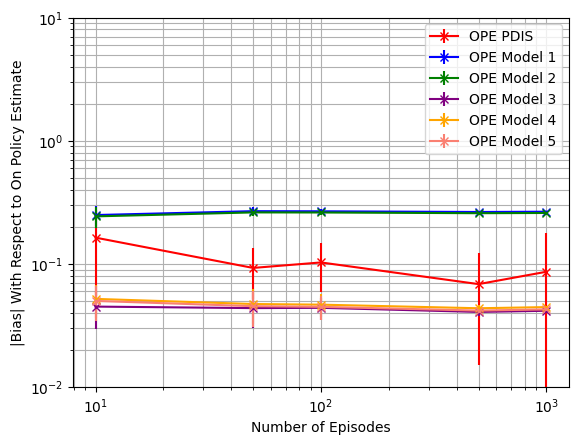

In [ ]:
bias_means = np.zeros((5,7))
bias_stds = np.zeros((5,7))

bias_means[:, 0] = bias_means_m1[:, 0]
bias_stds[:, 0] = bias_stds_m1[:, 0]

bias_means[:, 1] = bias_means_m1[:, 1]
bias_stds[:, 1] = bias_stds_m1[:, 1]

bias_means[:, 2] = bias_means_m1[:, 2]
bias_stds[:, 2] = bias_stds_m1[:, 2]

bias_means[:, 3] = bias_means_m2[:, 2]
bias_stds[:, 3] = bias_stds_m2[:, 2]

bias_means[:, 4] = bias_means_m3[:, 2]
bias_stds[:, 4] = bias_stds_m3[:, 2]

bias_means[:, 5] = bias_means_m4[:, 2]
bias_stds[:, 5] = bias_stds_m4[:, 2]

bias_means[:, 6] = bias_means_m5[:, 2]
bias_stds[:, 6] = bias_stds_m5[:, 2]

plot_graphs(bias_means, bias_stds, 'bias', 10**(-2), 10**1, estimator='neural-network')

### Variance

On Policy-----[0.0198837  0.00304474 0.00201086 0.00050622 0.00023069]
OPE PDIS-----[0.48801806 0.15911505 0.09560809 0.12876436 0.29759001]
OPE Model 1-----[0.01270633 0.00335855 0.00156845 0.00026119 0.00012145]
OPE Model 2-----[0.0129553  0.00330969 0.00145212 0.00025004 0.000117  ]
OPE Model 3-----[3.36393752e-04 1.10629637e-04 5.37479020e-05 8.53240027e-06
 4.34417976e-06]
OPE Model 4-----[3.18564305e-04 5.41777700e-05 2.51006197e-05 5.35381303e-06
 2.45329005e-06]
OPE Model 5-----[3.21567717e-04 5.49787301e-05 2.59623918e-05 5.35222478e-06
 2.49751553e-06]


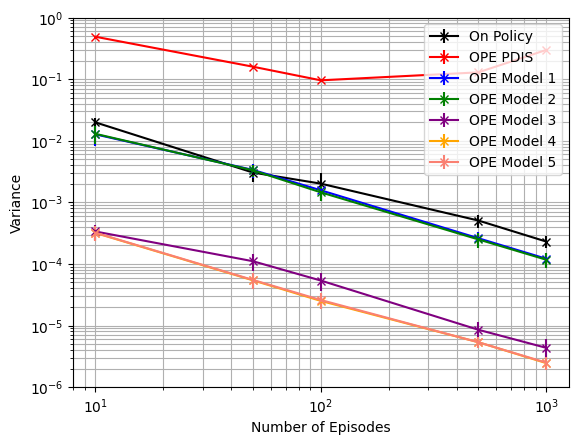

In [ ]:
var_means = np.zeros((5,7))
var_stds = np.zeros((5,7))

var_means[:, 0] = var_means_m1[:, 0]
var_stds[:, 0] = var_stds_m1[:, 0]

var_means[:, 1] = var_means_m1[:, 1]
var_stds_m1[:, 1] = var_stds_m1[:, 1]

var_means[:, 2] = var_means_m1[:, 2]
var_stds[:, 2] = var_stds_m1[:, 2]

var_means[:, 3] = var_means_m2[:, 2]
var_stds[:, 3] = var_stds_m2[:, 2]

var_means[:, 4] = var_means_m3[:, 2]
var_stds[:, 4] = var_stds_m3[:, 2]

var_means[:, 5] = var_means_m4[:, 2]
var_stds[:, 5] = var_stds_m4[:, 2]

var_means[:, 6] = var_means_m5[:, 2]
var_stds[:, 6] = var_stds_m5[:, 2]

plot_graphs(var_means, var_stds, 'var', 10**(-6), 10**0, estimator='neural-network')

### MSE

On Policy-----[0.0198837  0.00304474 0.00201086 0.00050622 0.00023069]
OPE PDIS-----[0.52659958 0.16938444 0.10812931 0.13631706 0.31341556]
OPE Model 1-----[0.07712609 0.07561103 0.07323955 0.06994777 0.07052916]
OPE Model 2-----[0.07420823 0.07226036 0.0700107  0.06684923 0.06727508]
OPE Model 3-----[0.00260377 0.00221772 0.00207374 0.00167757 0.0017409 ]
OPE Model 4-----[0.00326782 0.00250621 0.00230312 0.00191864 0.00199499]
OPE Model 5-----[0.00307805 0.00232932 0.00213117 0.00175907 0.00183145]


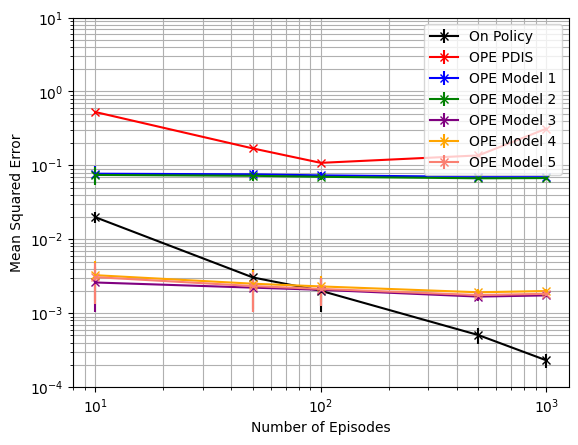

In [ ]:
mse_means = np.zeros((5,7))
mse_stds = np.zeros((5,7))

mse_means[:, 0] = mse_means_m1[:, 0]
mse_stds[:, 0] = mse_stds_m1[:, 0]

mse_means[:, 1] = mse_means_m1[:, 1]
mse_stds_m1[:, 1] = mse_stds_m1[:, 1]

mse_means[:, 2] = mse_means_m1[:, 2]
mse_stds[:, 2] = mse_stds_m1[:, 2]

mse_means[:, 3] = mse_means_m2[:, 2]
mse_stds[:, 3] = mse_stds_m2[:, 2]

mse_means[:, 4] = mse_means_m3[:, 2]
mse_stds[:, 4] = mse_stds_m3[:, 2]

mse_means[:, 5] = mse_means_m4[:, 2]
mse_stds[:, 5] = mse_stds_m4[:, 2]

mse_means[:, 6] = mse_means_m5[:, 2]
mse_stds[:, 6] = mse_stds_m5[:, 2]

plot_graphs(mse_means, mse_stds, 'MSE', 10**(-4), 10**1, estimator='neural-network')

### ESS

On Policy-----[  10.   50.  100.  500. 1000.]
OPE PDIS-----[0.96754329 1.01742905 3.85400693 5.8411064  7.14669253]
OPE Model 1-----[  16.93318479   48.03494045  133.64523018 1084.63805377 2003.24804563]
OPE Model 2-----[  16.13680047   46.92723924  148.74281662 1158.97527453 2106.6022002 ]
OPE Model 3-----[  639.94129985  1431.45048279  4331.25914783 31548.74712977
 58195.11560411]
OPE Model 4-----[  658.11164966  2874.932088    8227.06260493 47677.32267986
 97389.82105548]
OPE Model 5-----[  651.13699092  2835.53919925  7969.77503827 47787.41929487
 95250.91834767]


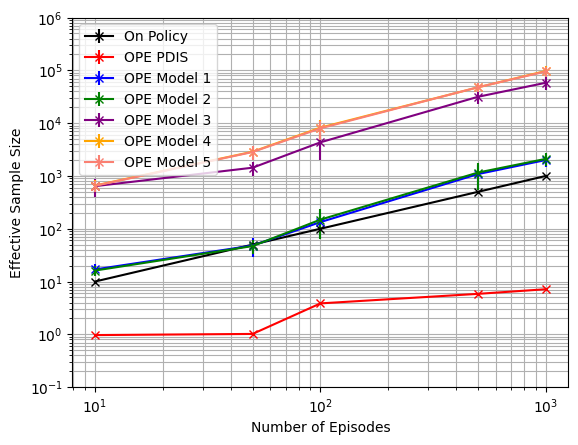

In [ ]:
ess_means = np.zeros((5,7))
ess_stds = np.zeros((5,7))

ess_means[:, 0] = ess_means_m1[:, 0]
ess_stds[:, 0] = ess_stds_m1[:, 0]

ess_means[:, 1] = ess_means_m1[:, 1]
ess_stds_m1[:, 1] = ess_stds_m1[:, 1]

ess_means[:, 2] = ess_means_m1[:, 2]
ess_stds[:, 2] = ess_stds_m1[:, 2]

ess_means[:, 3] = ess_means_m2[:, 2]
ess_stds[:, 3] = ess_stds_m2[:, 2]

ess_means[:, 4] = ess_means_m3[:, 2]
ess_stds[:, 4] = ess_stds_m3[:, 2]

ess_means[:, 5] = ess_means_m4[:, 2]
ess_stds[:, 5] = ess_stds_m4[:, 2]

ess_means[:, 6] = ess_means_m5[:, 2]
ess_stds[:, 6] = ess_stds_m5[:, 2]

plot_graphs(ess_means, ess_stds, 'ESS', 10**(-1), 10**6, estimator='neural-network')

# Analyse Overall Factored Policy and Reward

In [14]:
#Generate all combinations of states and actions
from itertools import product

states = [i for i in range(720)]
actions = [i for i in range(8)]
combinations = torch.tensor( list(map(list, list(product(states, actions)))), dtype=torch.float32 )
sa_combinations = combinations.clone().detach().reshape((720, 8, 2))
print(combinations.shape)
print(sa_combinations.shape)

torch.Size([5760, 2])
torch.Size([720, 8, 2])


Set up evaluation policy

In [15]:
EVAL_EPSILON = 0.4

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [16]:
indices = np.array( list(map(list, list(product(states, actions)))) ).astype(int)
print(indices.shape)
pi_e = torch.tensor(evalPolSoft[indices[:, 0], indices[:, 1]].squeeze(), dtype=torch.float32)
pi_b = torch.tensor(randPol[indices[:, 0], indices[:, 1]].squeeze(), dtype=torch.float32)
r = torch.tensor(R[indices[:, 0], indices[:, 1]].squeeze(), dtype=torch.float32)

combined_input = torch.stack((pi_b, pi_e, r), axis=-1)
print(combined_input.shape)
sa_combined_input = combined_input.clone().detach().reshape((720, 8, 3))
print(sa_combined_input.shape)

(5760, 2)
torch.Size([5760, 3])
torch.Size([720, 8, 3])


In [17]:
print(sa_combined_input)

tensor([[[ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882],
         ...,
         [ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882]],

        [[ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882],
         ...,
         [ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882]],

        [[ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882],
         ...,
         [ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882]],

        ...,

        [[ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.0571, -0.2882],
         ...,
         [ 0.1250,  0.0571, -0.2882],
         [ 0.1250,  0.6000, -0.2882],
         [ 0.1250,  0.0571, -0.2882]],

        [[

## Load Models

In [18]:
#Takes in action and state
class FactorNetwork_sa(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 3*D),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [19]:
#Takes in policy values and reward at state and action
class FactorNetwork_pr(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 3*D),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

### Run any one of the below cells

In [51]:
model = FactorNetwork_sa(2)
model.load_state_dict(torch.load('./model1e004', map_location=torch.device('cpu')))
model.eval()
label = 'Model 1'

In [78]:
model = FactorNetwork_sa(3)
model.load_state_dict(torch.load('./model2e004', map_location=torch.device('cpu')))
model.eval()
label = 'Model 2'

In [20]:
model = FactorNetwork_pr(2)
model.load_state_dict(torch.load('./model3e004', map_location=torch.device('cpu')))
model.eval()
label = 'Model 3'

In [28]:
model = FactorNetwork_pr(3)
model.load_state_dict(torch.load('./model4e004', map_location=torch.device('cpu')))
model.eval()
label = 'Model 4'

In [36]:
model = FactorNetwork_pr(4)
model.load_state_dict(torch.load('./model5e004', map_location=torch.device('cpu')))
model.eval()
label = 'Model 5'

## Model 1

In [29]:
#Over all states and actions
model(combinations)

tensor([[-0.0962,  0.2025,  0.0261,  0.2509, -0.0899,  0.0267],
        [-0.0840,  0.1650,  0.0376,  0.2667, -0.1328,  0.0111],
        [-0.0707,  0.1278,  0.0463,  0.2770, -0.1709, -0.0249],
        ...,
        [ 0.9245,  0.2231,  0.4957,  0.1248,  8.3104, -8.3451],
        [ 0.9165,  0.2332,  0.4850,  0.1491,  8.2968, -8.3236],
        [ 0.9086,  0.2433,  0.4743,  0.1734,  8.2832, -8.3022]],
       grad_fn=<AddmmBackward0>)

Specific states

In [39]:
a = model(sa_combinations[136])
factored_pi_b = a[:, :2]
factored_pi_e = a[:, 2:4]
factored_r = a[:, 4:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.11892227828502655
min factored pi_e 0.0681418925523758
max factored pi_b 0.2774263620376587
max factored pi_e 0.0681418925523758
sum of factored pi_bs over actions tensor([0.9657, 1.9488], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([1.3505, 0.7491], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.1269, -0.1525, -0.1781, -0.2037, -0.2293, -0.2549, -0.2805, -0.3061],
       grad_fn=<SumBackward1>)


In [52]:
e = model(sa_combinations[137])
factored_pi_b = e[:, :2]
factored_pi_e = e[:, 2:4]
factored_r = e[:, 4:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.12020847201347351
min factored pi_e 0.06835867464542389
max factored pi_b 0.27737101912498474
max factored pi_e 0.06835867464542389
sum of factored pi_bs over actions tensor([0.9760, 1.9484], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([1.3541, 0.7508], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.1262, -0.1518, -0.1774, -0.2030, -0.2286, -0.2541, -0.2797, -0.3053],
       grad_fn=<SumBackward1>)


In [38]:
b = model(sa_combinations[377])

factored_pi_b = b[:, :2]
factored_pi_e = b[:, 2:4]
factored_r = b[:, 4:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.1951894760131836
min factored pi_e 0.07196594774723053
max factored pi_b 0.45314157009124756
max factored pi_e 0.07196594774723053
sum of factored pi_bs over actions tensor([3.4931, 1.8394], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([2.2695, 1.0727], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.0448, -0.0369, -0.0291, -0.0263, -0.0519, -0.0775, -0.1031, -0.1287],
       grad_fn=<SumBackward1>)


In [40]:
c = model(sa_combinations[696])

factored_pi_b = c[:, :2]
factored_pi_e = c[:, 2:4]
factored_r = c[:, 4:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.17414653301239014
min factored pi_e 0.00798584520816803
max factored pi_b 0.929999589920044
max factored pi_e 0.00798584520816803
sum of factored pi_bs over actions tensor([7.2167, 1.6757], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([3.9637, 0.7438], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.0722, -0.0643, -0.0564, -0.0485, -0.0406, -0.0327, -0.0249, -0.0170],
       grad_fn=<SumBackward1>)


In [42]:
d = model(sa_combinations[100])

factored_pi_b = d[:, :2]
factored_pi_e = d[:, 2:4]
factored_r = d[:, 4:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.07260754704475403
min factored pi_e 0.0603400319814682
max factored pi_b 0.2794255018234253
max factored pi_e 0.0603400319814682
sum of factored pi_bs over actions tensor([0.5952, 1.9648], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([1.2221, 0.6867], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.1534, -0.1790, -0.2046, -0.2302, -0.2558, -0.2814, -0.3070, -0.3326],
       grad_fn=<SumBackward1>)


In [43]:
e = model(sa_combinations[0])

factored_pi_b = e[:, :2]
factored_pi_e = e[:, 2:4]
factored_r = e[:, 4:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b -0.12879261374473572
min factored pi_e 0.026071231812238693
max factored pi_b 0.20251962542533875
max factored pi_e 0.026071231812238693
sum of factored pi_bs over actions tensor([-0.5163,  0.3613], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([0.4616, 2.1533], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.0632, -0.1216, -0.1958, -0.2723, -0.3443, -0.4145, -0.4770, -0.5371],
       grad_fn=<SumBackward1>)


## Model 2

In [45]:
#Over all states and actions
model(combinations)

tensor([[ 2.2365e-01, -8.2321e-02,  1.7076e-02,  ..., -1.2213e-01,
          4.6376e-02, -2.3139e-01],
        [ 2.1584e-01, -6.3234e-02,  7.3417e-02,  ..., -1.6600e-01,
          3.1594e-02, -2.2910e-01],
        [ 2.0452e-01, -5.4736e-02,  1.1423e-01,  ..., -2.0164e-01,
          1.3105e-02, -2.2300e-01],
        ...,
        [ 1.4291e-02,  2.9534e+00,  1.7307e+01,  ..., -9.2907e+00,
         -1.1752e+01,  2.1179e+01],
        [ 5.8894e-03,  2.9467e+00,  1.7326e+01,  ..., -9.2883e+00,
         -1.1773e+01,  2.1190e+01],
        [-2.5081e-03,  2.9401e+00,  1.7345e+01,  ..., -9.2860e+00,
         -1.1794e+01,  2.1202e+01]], grad_fn=<AddmmBackward0>)

Specific states

In [79]:
a = model(sa_combinations[136])
factored_pi_b = a[:, :3]
factored_pi_e = a[:, 3:6]
factored_r = a[:, 6:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.1050204336643219
min factored pi_e 0.11126787215471268
max factored pi_b 3.3395957946777344
max factored pi_e 0.11126787215471268
sum of factored pi_bs over actions tensor([ 1.1238,  3.9322, 26.2293], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([ 7.2447,  2.0089, 11.5745], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.1854, -0.1926, -0.1998, -0.2071, -0.2143, -0.2215, -0.2324, -0.2592],
       grad_fn=<SumBackward1>)


In [80]:
e = model(sa_combinations[137])
factored_pi_b = e[:, :3]
factored_pi_e = e[:, 3:6]
factored_r = e[:, 6:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.1050051748752594
min factored pi_e 0.11293872445821762
max factored pi_b 3.36377215385437
max factored pi_e 0.11293872445821762
sum of factored pi_bs over actions tensor([ 1.1226,  3.9666, 26.4217], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([ 7.3088,  2.0224, 11.6620], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.1848, -0.1920, -0.1992, -0.2064, -0.2137, -0.2209, -0.2311, -0.2580],
       grad_fn=<SumBackward1>)


In [81]:
b = model(sa_combinations[377])

factored_pi_b = b[:, :3]
factored_pi_e = b[:, 3:6]
factored_r = b[:, 6:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.06471911072731018
min factored pi_e 0.5140560865402222
max factored pi_b 9.132969856262207
max factored pi_e 0.5140560865402222
sum of factored pi_bs over actions tensor([ 0.7530, 12.1130, 72.5323], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([22.8376,  5.2350, 32.5997], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.0377, -0.0449, -0.0521, -0.0594, -0.0666, -0.0738, -0.0810, -0.0883],
       grad_fn=<SumBackward1>)


In [82]:
c = model(sa_combinations[696])

factored_pi_b = c[:, :3]
factored_pi_e = c[:, 3:6]
factored_r = c[:, 6:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.002011209726333618
min factored pi_e 1.047206997871399
max factored pi_b 16.79287338256836
max factored pi_e 1.047206997871399
sum of factored pi_bs over actions tensor([  0.2513,  22.9267, 133.8115], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([43.4957,  9.5002, 60.4194], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([0.1578, 0.1506, 0.1434, 0.1362, 0.1289, 0.1217, 0.1145, 0.1072],
       grad_fn=<SumBackward1>)


In [83]:
d = model(sa_combinations[100])

factored_pi_b = d[:, :3]
factored_pi_e = d[:, 3:6]
factored_r = d[:, 6:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.10558107495307922
min factored pi_e 0.05110003799200058
max factored pi_b 2.46923828125
max factored pi_e 0.05110003799200058
sum of factored pi_bs over actions tensor([ 1.1657,  2.6918, 19.3004], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([4.9384, 1.5205, 8.4211], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.2074, -0.2147, -0.2219, -0.2291, -0.2364, -0.2490, -0.2758, -0.3027],
       grad_fn=<SumBackward1>)


In [84]:
e = model(sa_combinations[0])

factored_pi_b = e[:, :3]
factored_pi_e = e[:, 3:6]
factored_r = e[:, 6:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b -0.08232146501541138
min factored pi_e -0.16116228699684143
max factored pi_b 0.2896677851676941
max factored pi_e -0.16116228699684143
sum of factored pi_bs over actions tensor([ 1.6547, -0.3381,  1.3082], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([-1.0227, -0.7489,  0.1577], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.3071, -0.3635, -0.4115, -0.4530, -0.4911, -0.5279, -0.5634, -0.5994],
       grad_fn=<SumBackward1>)


## Model 3

In [21]:
model(combined_input)

tensor([[ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        ...,
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3750,  0.0363,  0.0612,  0.1981, -0.1653, -0.0544],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566]],
       grad_fn=<AddmmBackward0>)

Specific states

In [22]:
a = model(sa_combined_input[136])
print(a)
factored_pi_b = a[:, :2]
factored_pi_e = a[:, 2:4]
factored_r = a[:, 4:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3750,  0.0363,  0.0612,  0.1981, -0.1653, -0.0544],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566]],
       grad_fn=<AddmmBackward0>)
min factored pi_b 0.03634968400001526
min factored pi_e 0.04767424613237381
max factored pi_b 0.38811585307121277
max factored pi_e 0.04767424613237381
sum of factored pi_bs over actions tensor([3.0918, 0.3383], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([0.3950, 1.7405], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.2497, -0.2497, -0.2497, -0.2197, -0.2497, -0.2497, -0.2497, -0.2497],
       

In [23]:
e = model(sa_combined_input[137])
print(e)
factored_pi_b = e[:, :2]
factored_pi_e = e[:, 2:4]
factored_r = e[:, 4:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3750,  0.0363,  0.0612,  0.1981, -0.1653, -0.0544],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566]],
       grad_fn=<AddmmBackward0>)
min factored pi_b 0.03634968400001526
min factored pi_e 0.04767424613237381
max factored pi_b 0.38811585307121277
max factored pi_e 0.04767424613237381
sum of factored pi_bs over actions tensor([3.0918, 0.3383], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([0.3950, 1.7405], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.2497, -0.2497, -0.2497, -0.2197, -0.2497, -0.2497, -0.2497, -0.2497],
       

In [24]:
b = model(sa_combined_input[377])
print(b)
factored_pi_b = b[:, :2]
factored_pi_e = b[:, 2:4]
factored_r = b[:, 4:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.3750,  0.0363,  0.0612,  0.1981, -0.1653, -0.0544],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566]],
       grad_fn=<AddmmBackward0>)
min factored pi_b 0.03634968772530556
min factored pi_e 0.04767424613237381
max factored pi_b 0.38811585307121277
max factored pi_e 0.04767424613237381
sum of factored pi_bs over actions tensor([3.0918, 0.3383], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([0.3950, 1.7405], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.2197, -0.2497, -0.2497, -0.2497, -0.2497, -0.2497, -0.2497, -0.2497],
       

In [25]:
c = model(sa_combined_input[696])
print(c)
factored_pi_b = c[:, :2]
factored_pi_e = c[:, 2:4]
factored_r = c[:, 4:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3750,  0.0363,  0.0612,  0.1981, -0.1653, -0.0544]],
       grad_fn=<AddmmBackward0>)
min factored pi_b 0.03634968400001526
min factored pi_e 0.04767424613237381
max factored pi_b 0.38811585307121277
max factored pi_e 0.04767424613237381
sum of factored pi_bs over actions tensor([3.0918, 0.3383], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([0.3950, 1.7405], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.2497, -0.2497, -0.2497, -0.2497, -0.2497, -0.2497, -0.2497, -0.2197],
       

In [26]:
d = model(sa_combined_input[100])
print(d)
factored_pi_b = d[:, :2]
factored_pi_e = d[:, 2:4]
factored_r = d[:, 4:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3750,  0.0363,  0.0612,  0.1981, -0.1653, -0.0544],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566],
        [ 0.3881,  0.0431,  0.0477,  0.2203, -0.1931, -0.0566]],
       grad_fn=<AddmmBackward0>)
min factored pi_b 0.03634968400001526
min factored pi_e 0.04767424613237381
max factored pi_b 0.38811585307121277
max factored pi_e 0.04767424613237381
sum of factored pi_bs over actions tensor([3.0918, 0.3383], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([0.3950, 1.7405], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.2497, -0.2497, -0.2497, -0.2197, -0.2497, -0.2497, -0.2497, -0.2497],
       

In [27]:
e = model(sa_combined_input[0])

factored_pi_b = e[:, :2]
factored_pi_e = e[:, 2:4]
factored_r = e[:, 4:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.03634968400001526
min factored pi_e 0.04767424613237381
max factored pi_b 0.38811585307121277
max factored pi_e 0.04767424613237381
sum of factored pi_bs over actions tensor([3.0918, 0.3383], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([0.3950, 1.7405], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.2497, -0.2497, -0.2497, -0.2197, -0.2497, -0.2497, -0.2497, -0.2497],
       grad_fn=<SumBackward1>)


## Model 4

In [29]:
model(combined_input)

tensor([[ 0.0907,  0.0406,  0.1255,  ...,  0.0443, -0.0316, -0.2873],
        [ 0.0907,  0.0406,  0.1255,  ...,  0.0443, -0.0316, -0.2873],
        [ 0.0907,  0.0406,  0.1255,  ...,  0.0443, -0.0316, -0.2873],
        ...,
        [ 0.0907,  0.0406,  0.1255,  ...,  0.0443, -0.0316, -0.2873],
        [ 0.0843,  0.0434,  0.1290,  ...,  0.0476, -0.0230, -0.2834],
        [ 0.0907,  0.0406,  0.1255,  ...,  0.0443, -0.0316, -0.2873]],
       grad_fn=<AddmmBackward0>)

Specific states

In [30]:
a = model(sa_combined_input[136])
print(a)
factored_pi_b = a[:, :3]
factored_pi_e = a[:, 3:6]
factored_r = a[:, 6:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0843,  0.0434,  0.1290,  0.0269,  0.0409,  0.1042,  0.0476, -0.0230,
         -0.2834],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873]], grad_fn=<AddmmBackward0>)
min factored pi_b 0.04064264893531799
min factored pi_e 0.025895975530147552
max factored pi_b 0.12897005677223206
max factored pi_e 0.025895975530147552
sum of factored pi_

In [31]:
e = model(sa_combined_input[137])
print(e)
factored_pi_b = e[:, :3]
factored_pi_e = e[:, 3:6]
factored_r = e[:, 6:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0843,  0.0434,  0.1290,  0.0269,  0.0409,  0.1042,  0.0476, -0.0230,
         -0.2834],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873]], grad_fn=<AddmmBackward0>)
min factored pi_b 0.04064264893531799
min factored pi_e 0.025895975530147552
max factored pi_b 0.12897005677223206
max factored pi_e 0.025895975530147552
sum of factored pi_

In [32]:
b = model(sa_combined_input[377])
print(b)
factored_pi_b = b[:, :3]
factored_pi_e = b[:, 3:6]
factored_r = b[:, 6:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.0843,  0.0434,  0.1290,  0.0269,  0.0409,  0.1042,  0.0476, -0.0230,
         -0.2834],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873]], grad_fn=<AddmmBackward0>)
min factored pi_b 0.04064264893531799
min factored pi_e 0.025895975530147552
max factored pi_b 0.12897005677223206
max factored pi_e 0.025895975530147552
sum of factored pi_

In [33]:
c = model(sa_combined_input[696])
print(c)
factored_pi_b = c[:, :3]
factored_pi_e = c[:, 3:6]
factored_r = c[:, 6:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0843,  0.0434,  0.1290,  0.0269,  0.0409,  0.1042,  0.0476, -0.0230,
         -0.2834]], grad_fn=<AddmmBackward0>)
min factored pi_b 0.04064264893531799
min factored pi_e 0.025895975530147552
max factored pi_b 0.12897005677223206
max factored pi_e 0.025895975530147552
sum of factored pi_

In [34]:
d = model(sa_combined_input[100])
print(d)
factored_pi_b = d[:, :3]
factored_pi_e = d[:, 3:6]
factored_r = d[:, 6:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0843,  0.0434,  0.1290,  0.0269,  0.0409,  0.1042,  0.0476, -0.0230,
         -0.2834],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873],
        [ 0.0907,  0.0406,  0.1255,  0.0259,  0.0397,  0.0986,  0.0443, -0.0316,
         -0.2873]], grad_fn=<AddmmBackward0>)
min factored pi_b 0.04064264893531799
min factored pi_e 0.025895975530147552
max factored pi_b 0.12897005677223206
max factored pi_e 0.025895975530147552
sum of factored pi_

In [35]:
e = model(sa_combined_input[0])

factored_pi_b = e[:, :3]
factored_pi_e = e[:, 3:6]
factored_r = e[:, 6:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.04064264893531799
min factored pi_e 0.025895975530147552
max factored pi_b 0.12897005677223206
max factored pi_e 0.025895975530147552
sum of factored pi_bs over actions tensor([0.7192, 0.3279, 1.0077], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([0.2082, 0.3188, 0.7946], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.2746, -0.2746, -0.2746, -0.2587, -0.2746, -0.2746, -0.2746, -0.2746],
       grad_fn=<SumBackward1>)


## Model 5

In [37]:
model(combined_input)

tensor([[ 0.1148,  0.1522,  0.1494,  ...,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  ...,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  ...,  0.1650,  0.1978, -0.3366],
        ...,
        [ 0.1148,  0.1522,  0.1494,  ...,  0.1650,  0.1978, -0.3366],
        [ 0.1095,  0.1492,  0.1212,  ...,  0.1762,  0.2410, -0.3477],
        [ 0.1148,  0.1522,  0.1494,  ...,  0.1650,  0.1978, -0.3366]],
       grad_fn=<AddmmBackward0>)

Specific states

In [38]:
a = model(sa_combined_input[136])
print(a)
factored_pi_b = a[:, :4]
factored_pi_e = a[:, 4:8]
factored_r = a[:, 8:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1095,  0.1492,  0.1212,  0.2944,  0.1565,  0.0759,  0.0536,  0.0097,
         -0.2787,  0.1762,  0.2410, -0.3477],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.

In [39]:
e = model(sa_combined_input[137])
print(e)
factored_pi_b = e[:, :4]
factored_pi_e = e[:, 4:8]
factored_r = e[:, 8:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1095,  0.1492,  0.1212,  0.2944,  0.1565,  0.0759,  0.0536,  0.0097,
         -0.2787,  0.1762,  0.2410, -0.3477],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.

In [40]:
b = model(sa_combined_input[377])
print(b)
factored_pi_b = b[:, :4]
factored_pi_e = b[:, 4:8]
factored_r = b[:, 8:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.1095,  0.1492,  0.1212,  0.2944,  0.1565,  0.0759,  0.0536,  0.0097,
         -0.2787,  0.1762,  0.2410, -0.3477],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.

In [41]:
c = model(sa_combined_input[696])
print(c)
factored_pi_b = c[:, :4]
factored_pi_e = c[:, 4:8]
factored_r = c[:, 8:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1095,  0.1492,  0.1212,  0.2944,  0.1565,  0.0759,  0.0536,  0.0097,
         -0.2787,  0.1762,  0.

In [42]:
d = model(sa_combined_input[100])
print(d)
factored_pi_b = d[:, :4]
factored_pi_e = d[:, 4:8]
factored_r = d[:, 8:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

tensor([[ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1095,  0.1492,  0.1212,  0.2944,  0.1565,  0.0759,  0.0536,  0.0097,
         -0.2787,  0.1762,  0.2410, -0.3477],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.1978, -0.3366],
        [ 0.1148,  0.1522,  0.1494,  0.2617,  0.1180,  0.0602,  0.0039,  0.0036,
         -0.2798,  0.1650,  0.

In [43]:
e = model(sa_combined_input[0])

factored_pi_b = e[:, :4]
factored_pi_e = e[:, 4:8]
factored_r = e[:, 8:]

print(f'min factored pi_b {torch.min(factored_pi_b)}')
print(f'min factored pi_e {torch.min(factored_pi_e)}')
print(f'max factored pi_b {torch.max(factored_pi_b)}')
print(f'max factored pi_e {torch.min(factored_pi_e)}')
print(f'sum of factored pi_bs over actions {torch.sum(factored_pi_b, axis=0)}')
print(f'sum of factored pi_es over actions {torch.sum(factored_pi_e, axis=0)}')
print(f'sums of rewards across factored action spaces {torch.sum(factored_r, axis=1)}')

min factored pi_b 0.10950833559036255
min factored pi_e 0.003584533929824829
max factored pi_b 0.2944464087486267
max factored pi_e 0.003584533929824829
sum of factored pi_bs over actions tensor([0.9131, 1.2145, 1.1670, 2.1263], grad_fn=<SumBackward1>)
sum of factored pi_es over actions tensor([0.9823, 0.4975, 0.0811, 0.0348], grad_fn=<SumBackward1>)
sums of rewards across factored action spaces tensor([-0.2536, -0.2536, -0.2536, -0.2091, -0.2536, -0.2536, -0.2536, -0.2536],
       grad_fn=<SumBackward1>)
